

# <font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:
# !pip install hyperopt
#!pip install imblearn
# !pip install mlflow
#!pip install numpy==1.21.6
#!pip install dill
#!pip install lime
#!pip install shap

#!pip install mlflow
#!pip install tensorflow

# File system management
import os
import sys
import pickle
import dill
from datetime import datetime
from collections import Counter
#import tensorflow

# Data manipulation
import numpy as np
import numpy.typing as npt
import pandas as pd

# Scikit-learn
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate,\
    cross_val_score, train_test_split, GridSearchCV, StratifiedKFold,\
    RepeatedStratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_curve,\
    roc_auc_score, f1_score, accuracy_score, average_precision_score,\
    fbeta_score, make_scorer, classification_report, confusion_matrix,\
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,\
    precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_sample_weight

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn import pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# Data drift
# from evidently.report import Report
# from evidently.metric_preset import DataDriftPreset

# Version tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


/home/raquelsp/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/raquelsp/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [2]:
#################################
#    -- NOTEBOOK SETTINGS --    #
#################################

%matplotlib inline
sns.set_theme(palette="Set1")
#palette4 = ["#253d85", "#618576", "#cba87d", "#faec4d"]
#palette5 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#faec4d"]
#palette6 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#dcd2a3", "#faec4d"]


# Random state
seed = 84


# Define training set size
TRAIN_SIZE = 0.8


# Define table for saving model results of data rebalancing esperiences
df_results = pd.DataFrame()

# Define table for saving model scores
df_scores_models = pd.DataFrame()

# Define table for saving probability threshold evaluation
#df_thresholds = pd.DataFrame()

In [3]:

# Personnal packages
import tools_dataframe
import tools_preprocessing
import tools_feat_engineering
import tools_modeling

2023-07-04 16:16:30.517323: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 16:16:30.552086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 16:16:30.552824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 16:16:31.141536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



<a id='notebook_settings'></a>


<br>


---
---

<font size="+1"> **NOTEBOOK SETTINGS** </font>

---



<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---


In [4]:

# -----------------------------------------------------------------------
# -- BUSINESS METRIC
# -----------------------------------------------------------------------

def custom_score(y_real, y_pred, tn_weighting=1, fp_weighting=-1, fn_weighting=-10, tp_weighting=1, **kwargs):
    '''
    Business metric designed to minimise the risk to the bank of granting a loan by penalising false negatives.
    '''
    # tn (true negative): the loan is refunded: the bank earns money. => to maximize
    # fp (false positive) : the loan is denied in error: the bank loses interest, loses profit but does not actually lose money (type I error).
    # fn (false negative) : the loan is approved but the customer defaulting: the bank loses money (type II error). => to minimise
    # tp (true positif) : the loan is rightly denied: the bank neither gains nor loses money.

    '''
    Parameters
    ----------
    y_real : real class, mandatory (0 or 1).
    y_pred : predicted class, mandatory (0 or 1).

    tn_weighting : Weighting of True Negative, optional (1 by default),
    fp_weighting : Weighting of False Positive rate, optional (-1 by default),
    fn_weighting : Weighting of False Negative rate, optional (-10 by default),
    tp_weighting : Weighting of True Positive rate, optional (1 by default),
    kwargs is ignored - added just to avoid errors if used to replace roc_auc_score with parameter zero_division = 0

    Returns
    -------
    score : normalised gain (between 0 and 1) a high score indicates better performance

    '''
    # Confusion matrix
    (tn, fp, fn, tp) = confusion_matrix(y_real, y_pred).ravel()


    # Real Gain
    real_gain = tn * tn_weighting + fp * fp_weighting + fn * fn_weighting + tp * tp_weighting

    # Maximum Gain : all predictions are correct
    gain_max = (fp + tn) * tn_weighting + (fn + tp) * tp_weighting

    # Minimum Gain : all predictions are false
    gain_min = (fp + tn) * fp_weighting + (fn + tp) * fn_weighting

    custom_score = (real_gain - gain_min) / (gain_max - gain_min)

    # Normalised gain (between 0 and 1) a high score indicates better performance
    return custom_score



# -----------------------------------------------------------------------
# -- CONFUSION MATRIX FOR BINARY CLASSIFICATION
# -----------------------------------------------------------------------

def construct_confusion_matrix(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)

    labels = ['Non-Defaulters', 'Defaulters']

    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix for : {title}')
    plt.ylabel('True Class')
    plt.xlabel('Predict Class')
    plt.show()



# ------------------------------------------------------------------------
# -- DATA BALANCE METHODS EVALUATION
# ------------------------------------------------------------------------

def balance_method_analysis(model, X_train, X_val, y_train, y_val,
                            df_results, title, show_table=True,
                            show_confusion_matrix=True):
    """
    Function to evaluate the data balance method that generates the most important score improvement.

    ------------
    @Parameters
    ------------
    model : initialized classification model, mandatory.
    X_train : train set matrix X, mandatory.
    X_val : validation set matrix X, mandatory.
    y_train : train set vecteur y, mandatory.
    y_val : test set, vecteur y, mandatory.
    df_results : dataframe for scores saving, mandatory
    title : experience name to record in the dataframe, mandatory.
    show_table : shows the results table (optional, default = True).

    ------------
    @Returns
    ------------
    df_results : Performance backup dataframe.
    y_pred : predictions from the tested model
    """
    # Start of execution
    time_start = datetime.now()

    # Training the model with the training set
    model.fit(X_train, y_train)

    # End of train exectuion
    time_end_train = datetime.now()

    # Predictions with the validation set
    y_pred = model.predict(X_val)

    # End of prediction exectuion
    time_end = datetime.now()

    # Probabilities
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics computing
    # Recall
    recall = recall_score(y_val, y_pred)
    # Precision
    precision = precision_score(y_val, y_pred)
    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    # F-score ou Fbeta
    f1_score = fbeta_score(y_val, y_pred, beta=1)
    f2_score = fbeta_score(y_val, y_pred, beta=2)
    f5_score = fbeta_score(y_val, y_pred, beta=5)
    f10_score = fbeta_score(y_val, y_pred, beta=10)
    # Score ROC AUC
    roc_auc = roc_auc_score(y_val, y_proba)
    # Score AP
    ap_score = average_precision_score(y_val, y_proba)
    # Bussines metric
    bussines_metric = custom_score(y_val, y_pred)

    # Training runtime
    time_exec_train = time_end_train - time_start
    # Training+validation runtime
    time_execution = time_end - time_start

    # TN, FP, FN, TP
    (tn, fp, fn, tp) = confusion_matrix(y_val, y_pred).ravel()

    # cross validation
    scoring = ['roc_auc', 'recall', 'precision']
    scores = cross_validate(model, X_train, y_train, cv=10,
                            scoring=scoring, return_train_score=True)

    # Saving Performance dataframe
    df_results = pd.concat([df_results,(pd.DataFrame({
        'Experience': [title],
        'Bussines_score': [bussines_metric],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy],
        'F1': [f1_score],
        'F2': [f2_score],
        'F5': [f5_score],
        'F10': [f10_score],
        'ROC_AUC': [roc_auc],
        'AP_SCORE': [ap_score],
        'Train runtime': [time_exec_train],
        'Train+Validatin runtime': [time_execution],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'TP': [tp],
        # Cross-validation
        'Train_roc_auc_CV': [scores['train_roc_auc'].mean()],
        'Train_roc_auc_CV +/-': [scores['train_roc_auc'].std()],
        'Test_roc_auc_CV': [scores['test_roc_auc'].mean()],
        'Test_roc_auc_CV +/-': [scores['test_roc_auc'].std()],
        'Train_recall_CV': [scores['train_recall'].mean()],
        'Train_recall_CV +/-': [scores['train_recall'].std()],
        'Test_recall_CV': [scores['test_recall'].mean()],
        'Test_recall_CV +/-': [scores['test_recall'].std()],
        'Train_precision_CV': [scores['train_precision'].mean()],
        'Train_precision_CV +/-': [scores['train_precision'].std()],
        'Test_precision_CV': [scores['test_precision'].mean()],
        'Test_precision_CV +/-': [scores['test_precision'].std()],
    }))], axis =0)

    #dumping the model to pickle file
    with open('model_tests/df_results_scores.pkl', 'wb') as f:
        pickle.dump(df_results, f)

    if show_table:
        mask = df_results['Experience'] == title
        display(df_results[mask].style.hide(axis="index"))

    if show_confusion_matrix:
        construct_confusion_matrix(y_val, y_pred, title)

    return df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp




In [5]:
# --------------------------------------------------------------------
# -- MLFlow
# --------------------------------------------------------------------


def log_mlflow(model, title, Bussines_Metric,
               n_estimator=None, max_depth=None,
               Recall=None, Precision=None, Accuracy=None,
               F1_score=None, F2_score=None, F5_score=None, F10_score=None,
               Roc_auc=None, AP_score=None,
               TN=None, FP=None, FN=None, TP=None,
               train_class_0=None, train_class_1=None):

    '''
    Function to log model to MLFlow

    -----------
    @Parameters
    -----------
    model : initialized classification model, mandatory.
    title : experience name to record in the dataframe, mandatory.

    bussines_metric : value of the bussines metric, mandatory.
    n_estimator : optional (default = None).
    max_depth : optional (default = None).

    Recall : score value, optional (default = None).
    Precision : score value, optional (default = None).
    Accuracy : score value, optional (default = None).
    F1_score : score value, optional (default = None).
    F2_score : score value, optional (default = None).
    F5_score : score value, optional (default = None).
    F10_score : score value, optional (default = None).
    Roc_auc : score value, optional (default = None).
    AP_score : score value, optional (default = None).

    TN: true negative, optional (default = None).
    FP: false positive, optional (default = None).
    FN: false negative, optional (default = None).
    TP: true positif, optional (default = None).

    train_class_0 : optional (default = None).
    train_class_1 : optional (default = None).

    -----------
    @Returns
    -----------
    None
    '''

    # Track params and metrics
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", title)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("Train_class_0", train_class_0)
        mlflow.log_param("Train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric('Recall', Recall)
        mlflow.log_metric('Precision', Precision)
        mlflow.log_metric('Accuracy', Accuracy)
        mlflow.log_metric('F1', F1_score)
        mlflow.log_metric('F2', F2_score)
        mlflow.log_metric('F5', F5_score)
        mlflow.log_metric('F10', F10_score)
        mlflow.log_metric('ROC_AUC', Roc_auc)
        mlflow.log_metric('AP_SCORE', AP_score)
        mlflow.log_metric('Bussines_score', Bussines_Metric)
        mlflow.log_metric('TN', TN)
        mlflow.log_metric('FP', FP)
        mlflow.log_metric('FN', FN)
        mlflow.log_metric('TP', TP)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, title)

    mlflow.end_run()

In [6]:

# -------------------------------------------------
#    -- FONCTION FOR TESTING METRICS PERFORMANCE
# -------------------------------------------------

def performance_metrics(y_true, y_pred, y_proba=None):
    """
    Calculation of several metrics (to add to gridsearch cross-validated  results) for more precise measures of these metrics (mean, std), run cross_validation on metrics.

    Example:
    > scoring = ['roc_auc','precision', 'recall', 'f1','accuracy']
    > res = sklearn.model_selection.cross_validate(best_model, X_val, y_val, cv=5, scoring=scoring) 
    """
    
    # TN, FP, FN, TP
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    
    performance = dict(
        # Recall
        recall = recall_score(y_true, y_pred),
        # Precision
        precision = precision_score(y_true, y_pred),
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred),
        # F-score ou Fbeta
        f1_score = fbeta_score(y_true, y_pred, beta=1),
        f2_score = fbeta_score(y_true, y_pred, beta=2),
        f5_score = fbeta_score(y_true, y_pred, beta=5),
        f10_score = fbeta_score(y_true, y_pred, beta=10),
        # Bussines metric
        bussines_metric = custom_score(y_true, y_pred),
        # TN, FP, FN, TP
        tn = tn,
        fp = fp,
        fn = fn,
        tp = tp
    )

    if not y_proba is None:
        # Score ROC AUC
        performance['roc_auc'] = roc_auc_score(y_true, y_proba)
        # Score AP
        performance['ap_score'] = average_precision_score(y_true, y_proba)
    else:  # moins précis mais toujours valable
        # Score ROC AUC
        performance['roc_auc'] = roc_auc_score(y_true, y_pred)
        # Score AP
        performance['ap_score'] = average_precision_score(y_true, y_pred)

    for metric in performance.keys():
        performance[metric] = round(performance[metric], 3)

    return performance
    
    
###########################################
#    -- HYPERPARAMETER OPTIMIZATION --    #
############################################ 


# --------------------------------------------------------------------
# -- ROUND DIGITS
# --------------------------------------------------------------------

def round_digits(a_number, significant_digits=2):
    # https://stackoverflow.com/questions/374316/round-a-double-to-x-significant-figures
    try:
        return round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)
    except:
        # infinity, zero, NaN
        return a_number
    

# ---------------------------------------
#    -- IDENTIFY SCORERS TO OPTIMIZE
# ---------------------------------------

def get_scorers(grid_search_results):
    """
    If several scorers, mean scores for scorer with name {score} are in columns mean_test_{score}
    Note: columns mean_train{score} exist only if gridsearch with return_train_score=True
    """
    df = pd.DataFrame(grid_search_results)
    score_cols = df.columns[df.columns.str.startswith('mean_test_')].to_list()
    scorers = [col.replace('mean_test_', '') for col in score_cols]
    return scorers


# ---------------------------------------------------
# -- PLOT CURVE OF SCORERS FOR A GIVEN PARAMETER
# ---------------------------------------------------

def plot_best_param_scores(gs_, param='alpha', Experience='', scorers=None,
                           filter_other_params=True,
                           logx=False, ax=None, figsize=(6, 4),
                           errorbars=False):
    """
    Plot validation curve of 1 or more scorers, for a given parameter
    - adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
    
    @Parameters
    ------------
    gs_ : gridsearch for which the results are to be analysed
    param : parameter to evaluate
    Experience : title for graph, experience name
    scorers : scorers to optimize
    """
    # convert gridsearch results to dataframe to facilitate filtering and searching
    results = pd.DataFrame.from_dict(gs_.cv_results_)
    print(len(results))

    # Check parameter is in results
    param_key = f'param_{param}'
    if not param_key in results.columns:
        return f'{param_key} not in cross-validation results'

    # Check we can plot the parameter
    best_param = gs_.best_params_[param]
    if not isinstance(best_param, (int, float)):
        return 'param is not a number'
    else:
        print('best_param', best_param)

    # Filter gridsearch results of other parameters (True by default)
    if filter_other_params == True:
        # Filter by all gridsearch best params, except chosen param
        # If we don't filter, we will see lines for every permutation of gridsearch
        filtre = results.index == results.index

        for key in gs_.best_params_.keys():
            # print(f'key={key}, param_key={param_key}')
            if key != param:
                # check results were obtained
                res = results[results[f'param_{key}'] == gs_.best_params_[key]]
                if len(res) > 0:
                    # add to filter
                    filtre &= results[f'param_{key}'] == gs_.best_params_[key]

        # Check we have more than 2 points to plot (otherwise, return a table of 2 rows)
        res = results[filtre].copy()
        print(res.shape)
        results = res.copy()

        if len(results) < 3:
            print('not enough points to plot (< 3 results)')
            return results

    # If several scorers, scores for scorer with name {score} are in columns
    #  mean_train_{score}, std_train_{score}, mean_test_{score}, std_test_{score}
    scorer_keys=[]
    # get list of scorer keys:
    if scorers is None:
        scorer_keys = get_scorers(results)
    elif isinstance(scorers, str):
        scorer_keys = [scorers]
    elif isinstance(scorers, list):
        scorer_keys = scorers.copy()
    elif isinstance(scorers, dict):
        scorer_keys = list(scorers.keys())

    # If only one scorer for gridsearch, scores are in columns:
    # - mean_train_score, std_train_score, mean_test_score, std_test_score
    scorer_keys.append('score')

    # check scorer exists in results:
    for score in scorer_keys:
        if not f'mean_test_{score}' in results.columns:
            scorer_keys.remove(score)

    colors = sns.color_palette('tab10', n_colors=len(scorer_keys)).as_hex()

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_axis = np.array(results[param_key], dtype=float)

    # For each scorer, plot the mean+-std for train set and test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        for sample, style in (('train', '--'), ('test', '-')):
            mean_col = f'mean_{sample}_{scorer}'
            std_col = f'std_{sample}_{scorer}'
            sample_score_mean = results[mean_col] if mean_col in results.columns else None
            sample_score_std = results[std_col] if std_col in results.columns else None
            if not sample_score_mean is None and not sample_score_std is None:
                if errorbars:
                    # alternative visualisation
                    plt.errorbar(x=x_axis, y=sample_score_mean, yerr=sample_score_std,
                                 ls=style, color=color, alpha=1 if sample == 'test' else 0.7,
                                 label=f'{scorer} ({sample})')
                else:
                    ax.fill_between(
                        x_axis,
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == "test" else 0,
                        color=color,
                    )
            if not sample_score_mean is None and not errorbars:
                ax.plot(
                    x_axis,
                    sample_score_mean,
                    ls=style,
                    marker='+',
                    color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label=f'{scorer} ({sample})',
                )

    plt.grid(False)
    y_min, y_max = plt.ylim()

    # For each scorer, annotate the best score for the test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        rank_test_scorer = f'rank_test_{scorer}'
        if rank_test_scorer in results.columns:
            # filter by top_ranked_scores (only 1 row if filter_other_params=True)
            top_ranked = results[results[rank_test_scorer] == 1]
            # within top-ranked, assume greater(absolute value) is better
            mean_test_score = f'mean_test_{scorer}'
            abs_best_score = np.abs(top_ranked[mean_test_score]).max()
            best_result = top_ranked[np.abs(
                top_ranked[mean_test_score]) == abs_best_score].head(1)
            # get value of cell (could be max, min, mean, first...)
            best_score_val = best_result[mean_test_score].max()
            best_param_val = best_result[param_key].max()

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([best_param_val]*2, [y_min, best_score_val], linestyle="-.", color=color,
                    marker="x", markeredgewidth=3, ms=8,)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score_val,
                        (best_param_val, best_score_val + 0.005))

    ax.vlines(best_param, y_min, y_max,
              label=f'gridsearch choice : {param} = {round_digits(best_param,3)}', linestyle="--", color="red")

    plt.xlabel(f'Parameter : {param}')
    titre = f'Validation Curve (parameter : {param})'
    if is_log_scale(results[param_key].values) or logx:
        plt.xscale('log')
    if len(scorer_keys) > 1:
        plt.ylabel('score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        plt.ylabel(f'score ({scorer_keys[0]})')
        # plt.legend(loc='best')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        titre += f' (scorer = {scorer_keys[0]})'
    plt.suptitle(f'{Experience}')
    plt.title(titre)
    plt.show()
    
    
# --------------------------------------------------------
#    -- HYPERPARAMETER OPTIMIZATION VIA CROSS VALIDATION
# --------------------------------------------------------

# Metrics
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
ap_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)
busines_scorer = make_scorer(custom_score, greater_is_better=True)

# Ditionary for GridSearchCV with the scorers
cv_scorers = {'roc_auc': roc_auc_scorer,
              'bussines_metric': busines_scorer,
              'f2_score': f2_scorer}

def search_best_model(Experience, estimator_, param_grid_,
                      X_train, y_train,
                      scoring_=cv_scorers,
                      refit_scorer='roc_auc',
                      return_train_score=True,
                      plot_param_grid_curves=False,
                      randomized_search=False,
                      n_iter=10):

    if randomized_search:
        # if grid search is long
        searchtype = 'RandomizedSearchCV'
        gs_ = RandomizedSearchCV(
            estimator=estimator_,
            param_distributions=param_grid,
            n_iter=n_iter,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            return_train_score=return_train_score
        )
    else:
        searchtype = 'GridSearchCV'
        gs_ = GridSearchCV(
            estimator=estimator_,
            param_grid=param_grid_,
            cv=5, #n_jobs=-1,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            pre_dispatch=2,
            return_train_score=return_train_score)

    # Launch gridsearch
    start = datetime.now()
    gs_.fit(X_train, y_train)
    end = datetime.now()

    cv_time = round((end-start).total_seconds(), 3)
    print(f'{searchtype} took {cv_time} s')

    if plot_param_grid_curves:
        for param in gs_.best_params_:
            print(f'param : {param}')
            plot_best_param_scores(
                gs_, param, Experience, scorers=refit_scorer)
            plt.show()

    return gs_


# ----------------------------------------------------
#    -- CREATE A TABLE FOR RECORDING MODELS SCORES
# ----------------------------------------------------

def add_model_score(Experience: str,
                    model: BaseEstimator,
                    train_time, gridsearch_time,
                    params: dict,
                    scores: dict,
                    metrics: dict,
                    df=df_scores_models):
    
    """Add the gridSearch results on x_train and y_train and the score on X_val and y_val"""
    
    
    global df_scores_models
    print(f'add_model_score, model = {Experience}')

    # Model identification
    model_keys = dict(Experience=Experience,
                      model=model)

    # 'params' contains gridsearch.best_params_
    gridsearch_results = dict(params=params,
                              gridsearch_time=gridsearch_time,
                              train_time=train_time)

    # 'metrics' provides the validation scores
    row = dict(**model_keys, **scores, **gridsearch_results, **metrics)

    #df = pd.concat([df,(pd.DataFrame({row}))], axis =0)

    df_scores_models = df_scores_models.append(row, ignore_index=True)
    return df


# ---------------------------------------------------------
#    -- TRAIN MODEL ON THE BEST PARAMETERS FROM GRIDSEARCH
# ---------------------------------------------------------


def train_best_params(Experience, gs_,
                      X_train, y_train, X_val, y_val,
                      score='roc_auc', threshold_=0.5, verbose=True) -> npt.ArrayLike:
    """
    Après grid search, récuperer le best model, fit sur train et score sur test, enregistre dans df_scores_models
    
    
    Returns
    --------
    predicted values (y_pred) for X_val
    """

    global df_scores_models
    best_model = gs_.best_estimator_
    best_params = gs_.best_params_

    cv = pd.DataFrame(gs_.cv_results_)

    # get scores
    scores = dict(best_cv_score=getattr(gs_, 'best_score_', np.NaN),  # mean_test_score
                  refit_time=getattr(gs_, 'refit_time_', np.NaN),  # train_time
                 )
    scorer_keys = get_scorers(cv)
    for scorer in scorer_keys:
        # gs.best_score_
        scores[f'mean_test_{scorer}'] = cv[f'mean_test_{scorer}'][gs_.best_index_].mean()
        scores[f'std_test_{scorer}'] = cv[f'std_test_{scorer}'][gs_.best_index_].mean()

        if f'mean_train_{scorer}' in cv.columns:
            # gridsearch with return_train_scores=True
            # helps measure bias and variance, but computationally expensive to keep measuring
            scores[f'mean_train_{scorer}'] = cv[f'mean_train_{scorer}'][gs_.best_index_].mean()
            scores[f'std_train_{scorer}'] = cv[f'std_train_{scorer}'][gs_.best_index_].mean()

    for key in scores.keys():
        scores[key] = round_digits(scores[key], 3)

    mean_fit_time = round_digits(cv[f'mean_fit_time'].mean())
    mean_score_time = round_digits(cv[f'mean_score_time'].mean())
    fit_time = len(cv)*mean_fit_time

    n_folds = gs_.n_splits_  # number of splits of training data
    n_iter = len(cv)  # Iterations per split
    gridsearch_time = round((mean_fit_time + mean_score_time)*n_folds * n_iter, 3)
    if verbose:
        # print(f'Best Estimator: {best_model}')
        print(f'Best Parameters: {best_params}')
        if f'mean_train_{score}' in cv.columns:
            print(f'Best Train Score ({score}) : {scores[f"mean_train_{score}"]:.3f}')
        if f'mean_test_{score}' in cv.columns:
            print(f'Best Test Score ({score}): {scores[f"mean_test_{score}"]:.3f}')

    start = datetime.now()
    best_model = gs_.best_estimator_
    best_model.fit(X_train, y_train)
    end = datetime.now()
    train_time = round((end-start).total_seconds(), 3)

    y_proba = best_model.predict_proba(X_val)[:,1]
    y_pred = (y_proba > threshold_)*1

    
    if verbose:
        print('bestmodel type = ', type(best_model))

    print(f'time_model ({Experience}; training time = {mean_fit_time} s; estimated gridsearch time ({(n_folds*n_iter)} splits) = {gridsearch_time} s')

    # only run performance metrics on best model
    dict_metrics = performance_metrics(y_val, y_pred)

    dict_metrics['discrimination_threshold'] = threshold_
    add_model_score(Experience=Experience,
                    model=best_model,
                    train_time=train_time,
                    gridsearch_time=gridsearch_time,
                    params=best_params,
                    scores=scores,
                    metrics=dict_metrics
                    )
    #dumping the model to pickle file
    with open('model_tests/df_scores_models.pkl', 'wb') as f:
        pickle.dump(df_scores_models, f)
        
    return y_proba


# --------------------------------------------
#    -- SCORE MODEL FOR DIFFERENT THRESHOLDS
# --------------------------------------------

def calc_threshold_scores(y_proba, y_val, thresholds= np.linspace(0.1, 0.9, 17)):
    """Score model for different thresholds"""
    df_thresh=pd.DataFrame()
    for thresh in thresholds:
        y_pred=(y_proba>thresh)*1
        metr=performance_metrics(y_val, y_pred)
        res=dict(discrimination_threshold=thresh)
        res=dict(**res,**metr)
        df_thresh=df_thresh.append(res, ignore_index=True)
    return df_thresh


# ---------------------------------------------------------
#    -- VISUALIZATION OF SCORES VS PROBABILITY THRESHOLDS
# ---------------------------------------------------------

#def plot_threshold_scores(y_proba, scorers=['roc_auc','f2','bank_scorer'], ax=None):
#    """Visualization of scores value depending on probability threshold"""
#    df_thresh= calc_threshold_scores(y_proba)
#    if isinstance(scorers, str):
#        scorers = [scorers]
#    if ax is None:
#        fig = plt.figure()
#        ax = plt.gca()
#    colors=sns.color_palette('tab10')
#    markers=['D','X','o','^','s','+']
#    for i,scorer in enumerate(scorers):
#        sns.lineplot(df_thresh['discrimination_threshold'],
#                    df_thresh[scorer], marker=markers[i], color=colors[i],
#                     label=scorer,ax=ax)
#    ax.legend(loc='best')
#    ylabel='score' if len(scorers) > 1 else f'score ({scorers[0]})'
#    ax.set_ylabel(ylabel)
#    sns.despine()
    
    
# -----------------------------------------------
#    -- DISPLAY THE SUMMARY RESULTS FOR A MODEL
# -----------------------------------------------

def plot_cm_roc(model_pipeline_: BaseEstimator, gs_, 
                X_train, y_train, X_val, y_val,
                y_proba=None,threshold_=0.5,
                Experience=None, titre=None):
    """
    plot confusion matrix, ROC and precision-recall curves
    model_pipeline can be a classifier or a pipeline with a classifier
    """
    # print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)

    if Experience is None:
        Experience = get_model_classname(model_pipeline_)
    best_params = gs_.best_params_
    print(f'Plotting results for {Experience} with best_params : {gs_.best_params_}')

    # ----- Recover best model (needed for plotting ROC / Precision-Recall curves from estimator)
    # plotting ROC from predictions gives underestimate of AUC - too few points
    try:
        best_model = gs_.best_estimator_
    except:
        model_pipeline_.set_params(**dict(gs_.best_params_))
        best_model = model_pipeline_

    # ensure model is fitted
    best_model.fit(X_train, y_train)

    # ------- Calculate probabilities of True Positive, if not already calculated
    if y_proba is None:        
        y_proba=best_model.predict_proba(X_val)[:,1]

    y_pred = (y_proba > threshold_)*1

    # --------Classification Report -------------------

    print(f'Classification_report (threshold={threshold_:.3f}):')
    print(classification_report(y_val,y_pred))

    # ----------Extract recall and precision for chosen threshold
    (TN, FP, FN, TP) = confusion_matrix(y_val, y_pred).ravel()
    TPR = TP/(TP+FN)
    FPR = 1 - TN / (TN + FP)
    recall = TPR
    precision = TP/(TP+FP)
    # recall=metrics.recall_score(y_val, y_pred)
    print(f'1-specificity(FPR) = {FPR:.2f}, sensitivity(TPR) {TPR:.2f}')

    # --------- Best thresholds ----------------------
    df_thresh = calc_threshold_scores(y_proba, y_val)

    def find_best_threshold(df_thresh_:pd.DataFrame,scorer='roc_auc'):
        max_score=df_thresh_[scorer].max()
        idx=df_thresh_[scorer].argmax()
        best_threshold=df_thresh_['discrimination_threshold'][idx]
        return best_threshold, max_score

    for scorer in ['roc_auc','f2_score','bussines_metric']:
        best_thresh, max_score=find_best_threshold(df_thresh, scorer)
        print(f'best threshold for {scorer} : {best_thresh:.3f} (score = {max_score:.3f})')

    # Initialise plots
    nb = 13  # keep gridspec square
    fig, _ = plt.subplots(figsize=(nb, 4))
    gridspec = fig.add_gridspec(12, nb)

    # ----------Plot Confusion matrices 
    ax = plt.subplot(gridspec[:4, :4])
    # metrics.ConfusionMatrixDisplay.from_estimator(model_pipeline_, X_val, pd.Series(y_val),normalize='true',cmap='Blues',ax=ax)
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, normalize='true', cmap='Blues', ax=ax, colorbar=False)
    ax.grid(False)
    plt.title('Confusion Matrix')

    ax = plt.subplot(gridspec[8:12, :4])
    # metrics.ConfusionMatrixDisplay.from_estimator(model_pipeline_, X_val, pd.Series(y_val),normalize='true',cmap='Blues',ax=ax)
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, normalize=None, cmap='Greens', ax=ax, colorbar=False)
    plt.title('counts')
    ax.grid(False)

    # -------- Plot ROC Curves ------

    ax = plt.subplot(gridspec[:, 4:8])
    ax.plot([0, 1], [0, 1], color='b', ls='--', label='no skill')
    RocCurveDisplay.from_estimator(
        best_model, X_train, y_train, name='train', c='g', ls='-.', ax=ax)
    RocCurveDisplay.from_estimator(
        best_model, X_val, y_val, name='test', c='r', ax=ax)

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([FPR]*2, [0, TPR], linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([0, FPR], [TPR]*2, color='k', ls='-.', lw=1, marker="x", markeredgewidth=1, ms=8,
            label=f'threshold = {threshold_:.2f}')


    # predict probabilities
    # yhat = best_model.predict_proba(X_val)
    # keep probabilities for the positive outcome only
    # yhat = yhat[:, 1]
    yhat=y_proba
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val, yhat)

    # Best geometric mean
    # calculate the g-mean for each threshold
    # gmeans = np.sqrt(tpr * (1-fpr))
    # # locate the index of the largest g-mean
    # ix = np.argmax(gmeans)
    # print (f'ix 1 = {ix}')
    # print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # print(f'Best Threshold={thresholds[ix]:.3f}, G-mean ={gmeans[ix]:.3f}')
    #
    # get the best threshold using Youden’s J statistic.
    # geometric mean of 
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold={thresholds[ix]:.3f}, Youden J ={J[ix]:.3f}')
    # plot the roc curve for the model
    ax.scatter(fpr[ix], tpr[ix], marker='o', color='r', label=f'best Youden J (t={thresholds[ix]:.3f})')

    ax.grid(True)
    ax.legend(loc='best')
    plt.title('ROC Curve')


    # -------- Plot Precision Recall curves

    ax = plt.subplot(gridspec[:, 9:])
    PrecisionRecallDisplay.from_estimator(
        best_model, X_val, y_val, name='test', ax=ax)
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([0, recall], [precision]*2,
            linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([recall]*2, [0, precision], color='k', ls='-.', marker="x",
            markeredgewidth=1, lw=1, ms=8, label='threshold=0.5')

    precision, recall, thresholds = precision_recall_curve(y_val, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall+1e-6)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}')
    ax.scatter(recall[ix], precision[ix], marker='o', color='r', label=f'Best F1-score (thresh={thresholds[ix]:.3f})')

    ax.legend(loc='best')
    ax.grid(False)
    plt.title('Precision - Recall Curve')

    for key in best_params.keys():
        best_params[key] = round_digits(best_params[key], 3)
    if titre is None:
        titre = f'{Experience} - Summary. \nbest params={best_params}'
    plt.suptitle(titre, y=1.05)


# -----------------------
#    -- EVALUATE MODEL
# -----------------------

def evaluate_model(title, estimator,
                   train_x,train_y,
                   test_x,test_y,
                   param_grid={}, threshold_=0.5):
    # GridSearch
    gs = search_best_model(title, estimator,param_grid, train_x, train_y)

    # score best model from grid search
    y_pred_proba_ = train_best_params(Experience, gs, train_x, train_y,
        test_x, test_y)

    y_pred_=(y_pred_proba_>threshold_)*1
    print(performance_metrics(test_y, y_pred_, y_pred_proba_))

    # Show summary reports for model
    plot_cm_roc(estimator, gs, train_x, train_y,
            test_x, test_y, y_pred_proba_, Experience=title)



<font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>



## <font color = '#0085dd'>**Table of content**</font>


[Librairies loading](#LOADING_LIBRARIES)<br>

[Functions used in this notebook](#USED_FUNCTIONS)<br>

---

[**Datasets**](#datasets)
 * [Description](#datasets_description)
   * [orders_dataset](#orders_dataset)
   * [customers_dataset](#customers_dataset)
   * [order_items](#order_items)
   * [products_dataset](#products_dataset)
   * [product_category_name_translation](#product_category_name_translation)
   * [sellers_dataset](#sellers_dataset)
   * [order_payments](#order_payments)
   * [order_reviews](#order_reviews)
   * [geolocation_dataset](#geolocation_dataset)<br>
<br>
 * [Columns preparation](#columns_preparation)
   * [Zip codes centroids calculation](#centroid_zipCode)
   * [Product category check and update](#cat_products)


[**Datasets joining**](#datasets_joining)
 * [Data description](#data_description)
 * [Evaluation of missing values](#missing_values)
 * [Column filling analysis](#column_fill)
 * [Row filling analysis](#row_filling)
 * [Features pre-selection](#features_preSelection)

[**Features engineering**](#features_engineering)
 * [Customers spatial distribution](#customers_spatial_distribution)
 * [RFM features](#RFM_features)
 * [Products](#products)
 * [Orders](#Orders)
 * [Dates](#dates)
 * [Joining customers information](#join_customers_datasets)
 * [Features analysis](#features_analysis)

[**Dataset for segmentation**](#segmentation_dataset)
<br>

---


<a id='datasets_loading'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Loading datasets** </span></span>


In [7]:
os.getcwd()

'/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit'

In [8]:
# Define the folder containing the files with the project data
P7_scoring_credit = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/"

os.chdir(P7_scoring_credit)

In [9]:
os.getcwd()

'/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit'

In [10]:
# -----------------------------
# Files loading:
# -----------------------------

# Open final train_dataset
path_train_data = \
    'preprocessing/train_data_feat_select_ML.pkl'

with open(path_train_data, 'rb') as f:
    train_data = pickle.load(f)


# Open final test_dataset
path_test_data = \
    'preprocessing/test_data_feat_select_ML.pkl'
os.makedirs(os.path.dirname(path_test_data), exist_ok=True)

<a id='data_preparation'></a>

## <span style='background:#0085dd'><span style='color:white'>Data preparation</span></span>

<a id='dataset_reduction'></a>


### <span style='background:#0075bc'><span style='color:white'>**Dataset reduction** </span></span>


In order to save resources and speed up the testing and optimisation stages, these stages will be performed on a reduced version of the dataset.

In [11]:
train_data.shape

(307511, 490)

In [12]:
target_counter = Counter(train_data.TARGET)
print("Number of entries:", target_counter)

# Print ratio
print("Target ratio in training dataset is 1:{:.0f}".format(target_counter[0] / target_counter[1]))

Number of entries: Counter({0: 282686, 1: 24825})
Target ratio in training dataset is 1:11


In [13]:
# The following method was used to create a sub-dataset  :
train_data_reduced = train_data.loc[np.random.choice(train_data.index, 25000, replace=False)]

#To use a stable dataset, I saved the one generated by the method described above.
path_sav_reduced_train = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/reduced_train_dataset.pkl'

with open(path_sav_reduced_train, 'wb') as f:
    pickle.dump(train_data_reduced, f, pickle.HIGHEST_PROTOCOL)

# Upload the reduced dataset
with open(path_sav_reduced_train, 'rb') as f:
    train_data_reduced = pickle.load(f)

In [14]:
reduced_target_counter = Counter(train_data_reduced.TARGET)
print("Number of entries:", reduced_target_counter)

# Print ratio
print("Target ratio in the reduced training dataset is 1:{:.0f}".format(reduced_target_counter[0] / reduced_target_counter[1]))

Number of entries: Counter({0: 23024, 1: 1976})
Target ratio in the reduced training dataset is 1:12


<a id='X_matrix_y_vector'></a>

### <span style='background:#0075bc'><span style='color:white'>Identification of y vector and X matrix</span></span>

**y vector ; TARGET**

In [15]:
# Define target
y_small = train_data_reduced.pop('TARGET')
print(f'y_small : {y_small.shape}')

y_small : (25000,)


**X matrix**

In [16]:
# Transfer of the customer identifier to the index for modelling purposes
train_data_reduced.set_index('SK_ID_CURR', inplace=True)
X_small = train_data_reduced
print(f'X_small : {X_small.shape}')

X_small : (25000, 488)


<a id='split_train_val'></a>

### <span style='background:#0075bc'><span style='color:white'>Split the data into training and validation sets</span></span>

The training dataset is divided into :
* X_train : to train the model and find the best hyperparameters
* X_val : to evaluate the model's performance

In [17]:
# Split dataset (filled)
X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(X_small, y_small,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y_small,
                                                  random_state=seed)

<a id='choice_metrics'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Choice of metrics** </span></span>


**Issue**
***
- For our problem :
    - the **defaulters** form the **positive** class,
    - the **non-defaulters** form the **negative** class.
- To minimise the loss of money, we must :
    - try not to predict a non-defaulting customer if they default ==> **minimise the number of false negatives (FN) (type II error)** (predicted non-defaulting but defaulting customer). If a defaulter is predicted not to default, the Home Credit Group will have lost all the money lent to the borrower. This is the biggest loss to the business.
    - We try not to predict a defaulter if the customer is not a defaulter, therefore **minimising false positives (FP) (type I error)** (class 1 defaulter when in reality it is not a defaulter). If a non-defaulter is predicted to default, the Home Crédit Group will have lost the interest on the sum lent to the borrower.

<a id='metrics_binary_classif'></a>

## <span style='background:#0085dd'><span style='color:white'>Metrics for binary classification</span></span>

**Metrics**
***
- **Recall**: the metric for determining the **true positive rate** (TP), which measures how many of all the positive observations have been classified as positive. To avoid losses, we need to detect all defaulters (positive class) and therefore **maximise the recall** metric.
$$Recall Score = \frac{TP}{FN + TP}$$

- **Precision**: this measures the number of observations predicted as positive (defaulting customer) that are actually positive.  The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. If a customer is predicted to default when in fact they do not, the loan will not be granted and interest will not be paid. You therefore need to **maximise 'Precision'**.
$$Precision Score = \frac{TP}{FP + TP}$$

- **F-measure or F1**: a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
    - In our case, we need to find the greatest number of truly positive observations (customer predicted as failing and actually failing) and the loss is less if a failing customer is predicted but does not actually fail (false positives), so **we will give priority to maximising recall at the expense of precision** (we are talking about Precision, not accuracy).
    - Setting the beta parameter for the Fbeta score gives more weight to recall (beta>1) than to precision (0<beta<1).<br>
    <br>

- **ROC AUC score**: the ROC AUC (Area Under the Receiver Operating Characteristic Curve) score is equivalent to calculating the rank correlation between the predictions and the target. From an interpretation point of view, it is more useful because it tells us that this metric shows how good your model is at ranking predictions. It tells you the probability that a randomly selected positive instance will be ranked higher than a randomly selected negative instance.<br>

- **Score AP** : Compute average precision (AP) from prediction scores. AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. A utiliser :
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - when you care more about the positive class than the negative class. If you care more about the positive class and therefore the PPV and TPR, you should opt for the Precision-Recall curve and the PR AUC (average precision).


**Notes:**
***
- The sklearn library can be used to calculate all your scores.
- The calculation and recording of the different scores while modeling is included within the function : <span style='background:LightBlue'>**tools_modeling.calculer_scores**</span>.

[Source](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)


<a id='bussines_score'></a>

## <span style='background:#0085dd'><span style='color:white'>Bussines score</span></span>


**Score penalising false negatives**
* The above metrics do not penalise false negatives, except for the Fbeta which, by using a value greater than 1, penalises false negatives.
* We will therefore create a business metric that attempts to optimise our classification model by customising the loss function to manually define the cost of false positives/negatives and true positives/negatives.
* This business metric is defined by the fonction <span style='background:LightBlue'>**tools_modeling.custom_score**</span>.

**Probability threshold**
* The default probability threshold value of 0.5 can also be set to try and optimise model performance for our business metric. The optimal threshold for switching from class 0 to class 1 should be determined for each model trained with the business metric as the score.
* The function defining the probability threshold is available at : <span style='background:LightBlue'>**tools_modeling.prob_threshold**</span>.

<a id='scores_selection'></a>

## <span style='background:#0085dd'><span style='color:white'>Scores selection</span></span>

To optimise the models, we will optimise the AUC (Area Under Curve), then optimise the threshold (probability threshold) for the bank's profit.
We will compare the performance of the best models by simulating total profit.

AUC optimisation seeks to minimise the number of false negatives (loan approved, but true value was defaulter) for the train dataset.
In the case of threshold optimisation, the aim is to maximise the profit for the train dataset, using a custom scorer that takes into account the cost of misclassifications for the bank.

We will perform a test on theoretical data in order to identify the scores that perform similar to the custom scorer.

In [18]:
# Function for comparing scores performances
def add_perf_metrics(df: pd.DataFrame= None,
                     title: str = 'none',
                     ARI: float = 0,
                     k: int = 0,
                     **kwargs):
    """ajout les resultats d'un model """
    global df_resultats
    if df is None:
        df = df_resultats

    resultats = dict(Experience=title)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df

In [19]:
# Optimal results
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 0, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(pd.DataFrame(), 'optimal', **perf)

# 1-each (TN,FN,FP,TP)
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, '1-each (TN,FN,FP,TP)', **perf)

# A few bad payers
y_true1 = [1, 1, 0, 1]
y_pred1 = [0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few bad payers', **perf)

# Many bad payers
y_true1 = [1, 1, 1, 1, 0, 1]
y_pred1 = [0, 0, 0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many bad payers', **perf)

# A frew wrong refusals
y_true1 = [0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few wrong refusals', **perf)

# Many wrong refusals
y_true1 = [0, 0, 0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many wrong refusals', **perf)



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [20]:
df_temp.sort_values(by='bussines_metric')

,Experience,recall,precision,accuracy,f1_score,f2_score,f5_score,f10_score,bussines_metric,tn,fp,fn,tp,roc_auc,ap_score
3,many bad payers,0.200,1.000,0.333,0.333,0.238,0.206,0.202,0.228,1,0,4,1,0.600,0.867
2,a few bad payers,0.333,1.000,0.500,0.500,0.385,0.342,0.336,0.371,1,0,2,1,0.667,0.833
1,"1-each (TN,FN,FP,TP)",0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,1,1,1,1,0.500,0.500
5,many wrong refusals,1.000,0.200,0.333,0.333,0.556,0.867,0.962,0.619,1,4,0,1,0.600,0.200
4,a few wrong refusals,1.000,0.333,0.500,0.500,0.714,0.929,0.981,0.765,1,2,0,1,0.667,0.333
0,optimal,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2,0,0,2,1.000,1.000


* The metric that shows the greatest affinity with the results of the custom_score is **f2_score**.
* When there are many false negatives (predictions of loans to bad payers), the bank score is similar to the recall. So we also want to maximise the recall of the TARGET==1 class.

In [21]:
# Metrics
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_proba=True)
ap_scorer = make_scorer(average_precision_score, greater_is_better=True,
                        needs_proba=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)
busines_scorer = make_scorer(tools_modeling.custom_score,
                             greater_is_better=True)

# Ditionary for GridSearchCV with the scorers
cv_scorers = {'roc_auc': roc_auc_scorer,
             'bussines_metric': busines_scorer,
             'f2_score': f2_scorer}


<a id='data_rebalancing'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Data rebalancing** </span></span>


In order to identify the most performant method of data rebalancing we will perform a first modelling using the default parameters.

**Raw data split**

In [58]:
y_s_train_counter = Counter(y_s_train)
print("Training target statistics:", y_s_train_counter)
y_s_val_counter = Counter(y_s_val)
print("Testing target statistics:", y_s_val_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(y_s_train_counter[0] / y_s_train_counter[1]))
print("Target ratio in validation dataset is 1:{:.0f}".format(y_s_val_counter[0] / y_s_val_counter[1]))

Training target statistics: Counter({0: 18321, 1: 1679})
Testing target statistics: Counter({0: 4580, 1: 420})

Target ratio in training dataset is 1:11
Target ratio in validation dataset is 1:11


**Data rebalancing using SMOTE**

In [59]:
# transform the dataset
oversample = SMOTE()

# transform the dataset
X_s_train_SMOTE, y_s_train_SMOTE = oversample.fit_resample(X_s_train, y_s_train)
#X_s_val_SMOTE, y_s_val_SMOTE = oversample.fit_resample(X_s_val, y_s_val)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f75d41de790>
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [60]:
y_s_train_SMOTE_counter = Counter(y_s_train_SMOTE)
print("Training target statistics:", y_s_train_SMOTE_counter)
# y_s_val_SMOTE_counter = Counter(y_s_val_SMOTE)
# print("Validation target statistics:", y_s_val_SMOTE_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(y_s_train_SMOTE_counter[0] / y_s_train_SMOTE_counter[1]))
# print("Target ratio in validation dataset is 1:{:.0f}".format(y_s_val_SMOTE_counter[0] / y_s_val_SMOTE_counter[1]))

Training target statistics: Counter({0: 18321, 1: 18321})

Target ratio in training dataset is 1:1


**Data rebalancing using SMOTE and RandomUnderSampler**

In [61]:
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline_under = imbpipeline.Pipeline(steps=steps)

# transform the dataset
X_s_train_SMOTE_UNDER, y_s_train_SMOTE_UNDER = pipeline_under.fit_resample(X_s_train, y_s_train)
#X_s_val_SMOTE_UNDER, y_s_val_SMOTE_UNDER = pipeline_under.fit_resample(X_s_val, y_s_val)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f75d41dec10>
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [62]:
y_s_train_SMOTE_UNDER_counter = Counter(y_s_train_SMOTE_UNDER)
print("Training target statistics:", y_s_train_SMOTE_UNDER_counter)

# y_s_val_SMOTE_UNDER_counter = Counter(y_s_val_SMOTE_UNDER)
# print("Testing target statistics:", y_s_val_SMOTE_UNDER_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(y_s_train_SMOTE_UNDER_counter[0] / y_s_train_SMOTE_UNDER_counter[1]))

# print("Target ratio in validation dataset is 1:{:.0f}".format(y_s_val_SMOTE_UNDER_counter[0] / y_s_val_SMOTE_UNDER_counter[1]))

Training target statistics: Counter({0: 9160, 1: 9160})

Target ratio in training dataset is 1:1


**Data rebalancing using class_weight**

In [63]:
class_weights = y_s_train_counter
class_weights

Counter({0: 18321, 1: 1679})

In [64]:
# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

<a id='rebalancing_model_tests'></a>

## <span style='background:#0085dd'><span style='color:white'>Models tests</span></span>

<a id='rebalancing_dummy'></a>

### <span style='background:#0075bc'><span style='color:white'>Baseline : Dummy Classifier</span></span>

In [65]:
# Without data balance
DC = DummyClassifier(strategy='most_frequent', random_state=seed)

# Using class_weight
''' Est-il possible d'utiliser class_weight avec DummyClassifier?'''

" Est-il possible d'utiliser class_weight avec DummyClassifier?"

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
dummy_class_defaultParams_unbalanced,0.664731,0.000000,0.000000,0.916000,0.000000,0.000000,0.000000,0.000000,0.500000,0.084000,0 days 00:00:00.001023,0 days 00:00:00.001328,4580,0,420,0,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


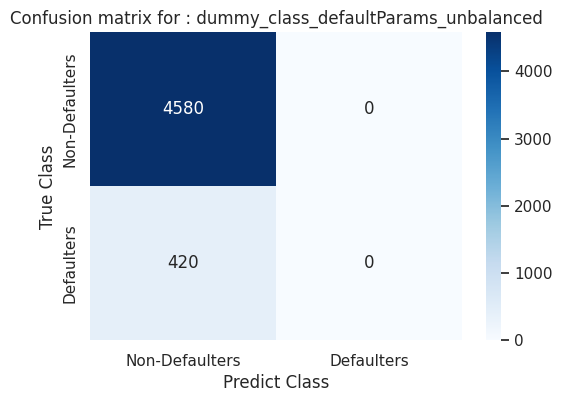

In [66]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score,f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(DC,
                                X_s_train, X_s_val,
                                y_s_train, y_s_val,
                                df_results,
                                'dummy_class_defaultParams_unbalanced')

In [67]:
# Default model hyperparameters and raw split
#df_results, recall, precision, accuracy, f1_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = tools_modeling.balance_method_analysis(DC,X_s_train, X_s_val, y_s_train, y_s_val, df_results,'dummy_class_defaultParams_unbalanced')

In [68]:
#os.getcwd()

In [69]:
# Load de table
#file_df_result_score = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/df_results_scores.pkl'
#with open(file_df_result_score, 'rb') as f:
#    df_results = pickle.load(f)

In [70]:
log_mlflow(DC, "dummy_class_defaultParams_unbalanced",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Setuptools is replacing distutils.


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
dummy_class_defaultParams_SMOTE,0.664731,0.000000,0.000000,0.916000,0.000000,0.000000,0.000000,0.000000,0.500000,0.084000,0 days 00:00:00.002182,0 days 00:00:00.002577,4580,0,420,0,0.500000,0.000000,0.500000,0.000000,0.100000,0.300000,0.100000,0.300000,0.050002,0.150005,0.049986,0.149959


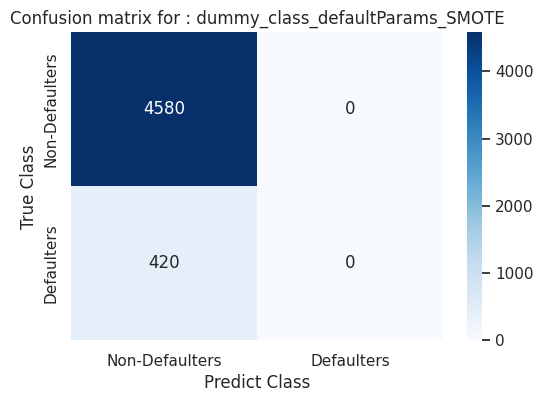

In [71]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(DC,
                                X_s_train_SMOTE, X_s_val,
                                y_s_train_SMOTE, y_s_val,
                                df_results,
                                'dummy_class_defaultParams_SMOTE')


In [72]:
log_mlflow(DC, "dummy_class_defaultParams_unbalanced",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
dummy_class_defaultParams_SMOTE,0.674690,0.000000,0.000000,0.919400,0.000000,0.000000,0.000000,0.000000,0.500000,0.080600,0 days 00:00:00.001936,0 days 00:00:00.002544,4597,0,403,0,0.500000,0.000000,0.500000,0.000000,0.300000,0.458258,0.300000,0.458258,0.150005,0.229136,0.149959,0.229066
dummy_class_defaultParams_SMOTE,0.674690,0.000000,0.000000,0.919400,0.000000,0.000000,0.000000,0.000000,0.500000,0.080600,0 days 00:00:00.002383,0 days 00:00:00.002916,4597,0,403,0,0.500000,0.000000,0.500000,0.000000,0.300000,0.458258,0.300000,0.458258,0.150005,0.229136,0.149959,0.229066


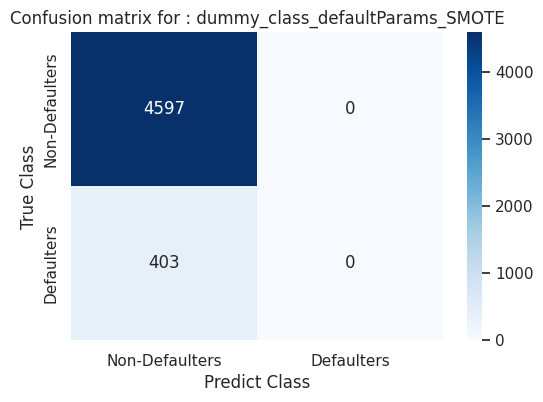

In [37]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(DC,
                                X_s_train_SMOTE, X_s_val,
                                y_s_train_SMOTE, y_s_val,
                                df_results,
                                'dummy_class_defaultParams_SMOTE')


In [38]:
log_mlflow(DC, "dummy_class_defaultParams_SMOTE",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
dummy_class_defaultParams_SMOTE_UNDER,0.674690,0.000000,0.000000,0.919400,0.000000,0.000000,0.000000,0.000000,0.500000,0.080600,0 days 00:00:00.001572,0 days 00:00:00.002094,4597,0,403,0,0.500000,0.000000,0.500000,0.000000,0.300000,0.458258,0.300000,0.458258,0.150009,0.229143,0.149918,0.229004


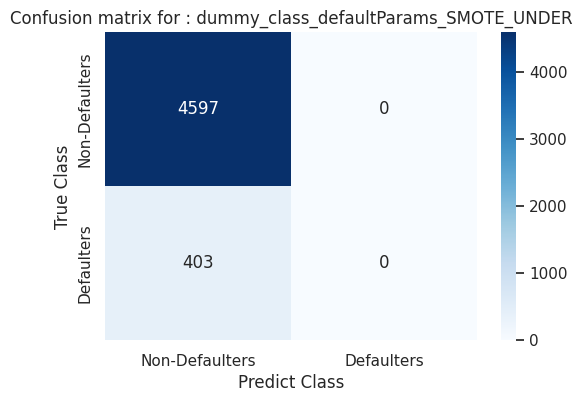

In [39]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = balance_method_analysis(DC,
                                           X_s_train_SMOTE_UNDER,
                                           X_s_val,
                                           y_s_train_SMOTE_UNDER,
                                           y_s_val,
                                           df_results,
                                     'dummy_class_defaultParams_SMOTE_UNDER')


In [40]:
log_mlflow(DC, "dummy_class_defaultParams_SMOTE_UNDER",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

<a id='rebalancing_LogisticRegression'></a>

### <span style='background:#0075bc'><span style='color:white'>Logistic regression</span></span>

In [41]:
# Without data balance
LR = LogisticRegression(random_state=seed)

# Using class_weight
LR_cw = LogisticRegression(class_weight='balanced', random_state=seed)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
logistic_regression_defaultParams_unbalanced,0.674543,0.000000,0.000000,0.919200,0.000000,0.000000,0.000000,0.000000,0.458921,0.071964,0 days 00:00:01.528773,0 days 00:00:01.563804,4596,1,403,0,0.478951,0.002483,0.475490,0.015015,0.002549,0.000976,0.001238,0.002477,0.237396,0.068079,0.075000,0.160078


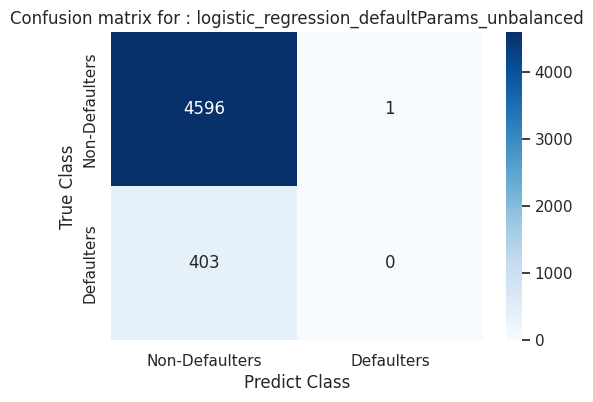

In [42]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_s_train, X_s_val, y_s_train, y_s_val,
                                df_results,
                               'logistic_regression_defaultParams_unbalanced')

In [43]:
log_mlflow(LR, "logistic_regression_defaultParams_unbalanced",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
logistic_regression_defaultParams_SMOTE,0.523299,0.612903,0.093667,0.490800,0.162500,0.290657,0.505192,0.581014,0.574346,0.108735,0 days 00:00:02.853013,0 days 00:00:02.932240,2207,2390,156,247,0.579409,0.001593,0.578672,0.009720,0.608661,0.006374,0.609233,0.014480,0.538764,0.001086,0.539670,0.007886


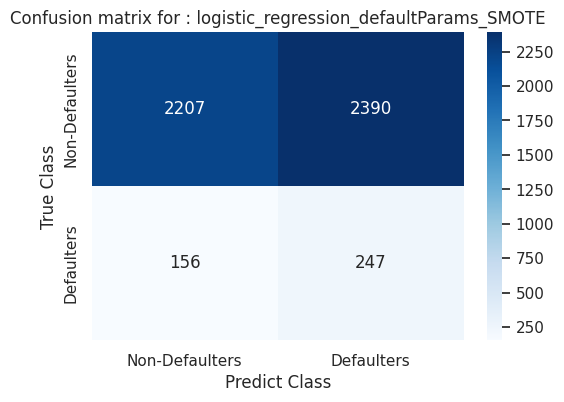

In [44]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_s_train_SMOTE, X_s_val,
                                y_s_train_SMOTE, y_s_val,
                                df_results,
                                'logistic_regression_defaultParams_SMOTE')


In [45]:
log_mlflow(LR, "logistic_regression_defaultParams_SMOTE",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
logistic_regression_defaultParams_SMOTE_UNDER,0.520070,0.593052,0.091676,0.493600,0.158804,0.283242,0.489986,0.562589,0.573321,0.109654,0 days 00:00:01.254761,0 days 00:00:01.289361,2229,2368,164,239,0.576415,0.001832,0.574306,0.012924,0.603043,0.005950,0.601978,0.017542,0.540247,0.001348,0.540097,0.008405


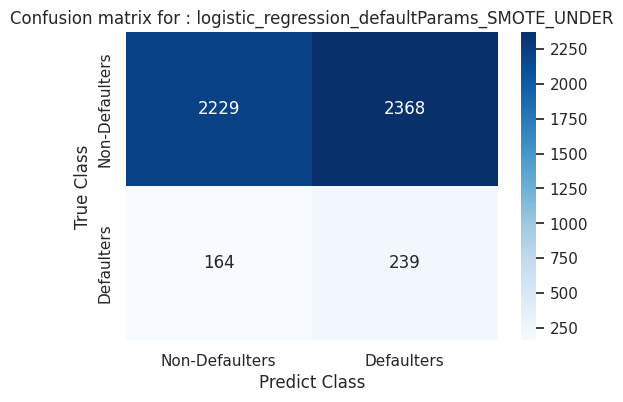

In [46]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_s_train_SMOTE_UNDER,
                                X_s_val,
                                y_s_train_SMOTE_UNDER,
                                y_s_val,
                                df_results,
                            'logistic_regression_defaultParams_SMOTE_UNDER')


In [47]:
log_mlflow(LR, "logistic_regression_defaultParams_SMOTE_UNDER",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
logistic_regression_defaultParams_classWeight,0.508916,0.632754,0.091496,0.464000,0.159875,0.289839,0.515472,0.597744,0.575133,0.109591,0 days 00:00:01.561435,0 days 00:00:01.598839,2065,2532,148,255,0.572109,0.002895,0.563747,0.031565,0.624579,0.010676,0.613101,0.048361,0.090163,0.000804,0.088813,0.006687


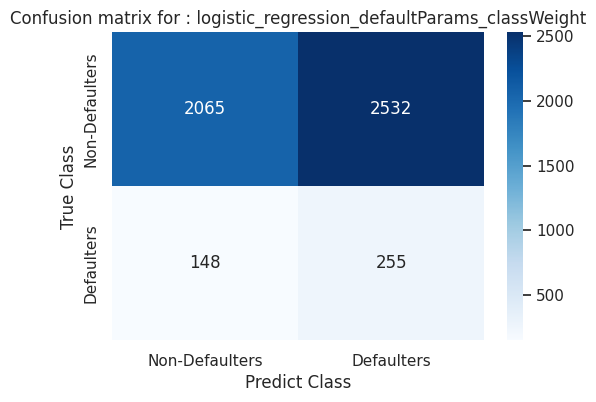

In [48]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR_cw,
                                X_s_train, X_s_val,
                                y_s_train, y_s_val,
                                df_results,
                            'logistic_regression_defaultParams_classWeight')


In [49]:
log_mlflow(LR_cw, "logistic_regression_defaultParams_classWeight",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

<a id='rebalancing_RandomForest'></a>

### <span style='background:#0075bc'><span style='color:white'>Random Forest</span></span>

In [50]:
# Without data balance
randomForest = RandomForestClassifier(random_state = seed)

# Using class_weight
randomForest_cw = RandomForestClassifier(class_weight = 'balanced',
                                         random_state = seed)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
RForestClass_defaultParams_unbalanced,0.676304,0.004963,1.000000,0.919800,0.009877,0.006196,0.005160,0.005012,0.748234,0.239655,0 days 00:00:20.519659,0 days 00:00:20.651777,4597,0,401,2,1.000000,0.000000,0.737288,0.017639,0.998898,0.000631,0.004954,0.005394,1.000000,0.000000,0.466667,0.476095


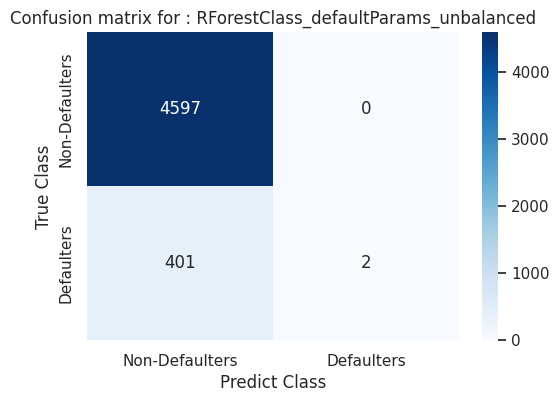

In [51]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_s_train, X_s_val, y_s_train, y_s_val,
                                df_results,
                                'RForestClass_defaultParams_unbalanced')

In [52]:
log_mlflow(randomForest, "RForestClass_defaultParams_unbalanced",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
RForestClass_defaultParams_SMOTE,0.677625,0.014888,0.315789,0.918000,0.028436,0.018394,0.015455,0.015030,0.735052,0.189674,0 days 00:00:33.715327,0 days 00:00:33.854044,4584,13,397,6,1.000000,0.000000,0.993023,0.020856,1.000000,0.000000,0.922458,0.228460,1.000000,0.000000,0.996102,0.002891


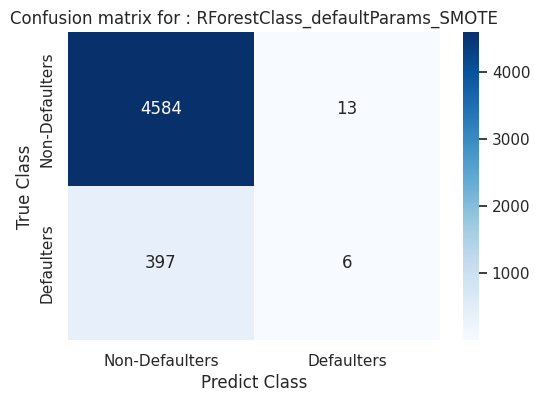

In [53]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_s_train_SMOTE, X_s_val,
                                y_s_train_SMOTE, y_s_val,
                                df_results,
                                'RForestClass_defaultParams_SMOTE')


In [54]:
log_mlflow(randomForest, "RForestClass_defaultParams_SMOTE",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
RForestClass_defaultParams_SMOTE_UNDER,0.695751,0.111663,0.302013,0.907600,0.163043,0.127768,0.114437,0.112364,0.736680,0.187770,0 days 00:00:14.211017,0 days 00:00:14.315045,4493,104,358,45,1.000000,0.000000,0.978296,0.043010,1.000000,0.000000,0.868663,0.259548,1.000000,0.000000,0.968076,0.009054


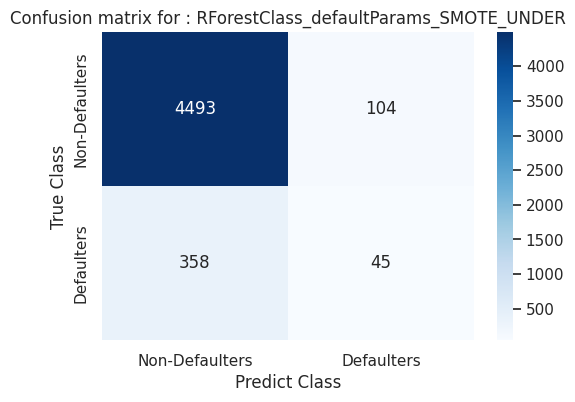

In [55]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_s_train_SMOTE_UNDER,
                                X_s_val,
                                y_s_train_SMOTE_UNDER,
                                y_s_val,
                                df_results,
                                'RForestClass_defaultParams_SMOTE_UNDER')


In [56]:
log_mlflow(randomForest, "RForestClass_defaultParams_SMOTE_UNDER",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
RForestClass_defaultParams_classWeight,0.674543,0.000000,0.000000,0.919200,0.000000,0.000000,0.000000,0.000000,0.737406,0.189169,0 days 00:00:11.489281,0 days 00:00:11.583148,4596,1,403,0,1.000000,0.000000,0.746092,0.008125,0.999105,0.000538,0.003719,0.004115,1.000000,0.000000,0.233333,0.249444


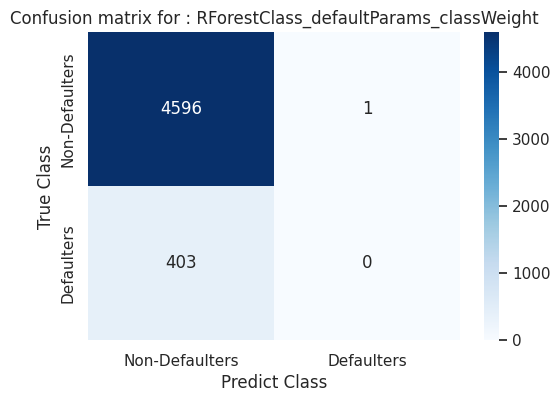

In [57]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest_cw,
                                X_s_train, X_s_val,
                                y_s_train, y_s_val,
                                df_results,
                                'RForestClass_defaultParams_classWeight')


In [58]:
log_mlflow(randomForest_cw, "RForestClass_defaultParams_classWeight",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

<a id='rebalancing_XGBoost'></a>

### <span style='background:#0075bc'><span style='color:white'>XG Boost</span></span>

In [59]:
# Without data balance
XGBClass = xgb.XGBClassifier(random_state = seed)

# Using class_weight
XGBClass_cw = xgb.XGBClassifier(scale_pos_weight = pos_weight,
                                class_weight=class_weights,
                                random_state = seed)

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
XGBClass_defaultParams_unbalanced,0.690027,0.066998,0.380282,0.916000,0.113924,0.080214,0.069190,0.067548,0.746448,0.221868,0 days 00:00:10.822246,0 days 00:00:10.854039,4553,44,376,27,0.999974,0.000021,0.742329,0.009955,0.965972,0.006487,0.071946,0.027715,1.000000,0.000000,0.436846,0.124826


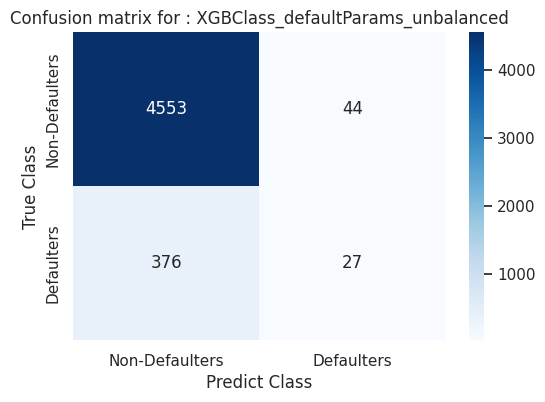

In [60]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_s_train, X_s_val, y_s_train, y_s_val,
                                df_results,
                                'XGBClass_defaultParams_unbalanced')

In [61]:
log_mlflow(XGBClass, "XGBClass_defaultParams_unbalanced",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
XGBClass_defaultParams_SMOTE,0.696412,0.094293,0.383838,0.914800,0.151394,0.111046,0.097110,0.095002,0.738049,0.216728,0 days 00:00:24.673985,0 days 00:00:24.695810,4536,61,365,38,0.999973,0.000012,0.977665,0.066979,0.992519,0.002633,0.912289,0.263132,0.999988,0.000024,0.986295,0.005233


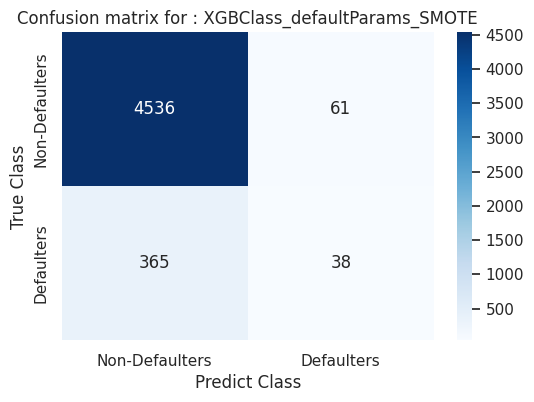

In [62]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_s_train_SMOTE, X_s_val,
                                y_s_train_SMOTE, y_s_val,
                                df_results,
                                'XGBClass_defaultParams_SMOTE')


In [63]:
log_mlflow(XGBClass, "XGBClass_defaultParams_SMOTE",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
XGBClass_defaultParams_SMOTE_UNDER,0.710942,0.183623,0.316239,0.902200,0.232339,0.200433,0.186633,0.184388,0.734781,0.218285,0 days 00:00:13.529750,0 days 00:00:13.571505,4437,160,329,74,0.999997,0.000003,0.964740,0.070423,0.997268,0.001477,0.843634,0.317121,1.000000,0.000000,0.943131,0.028631


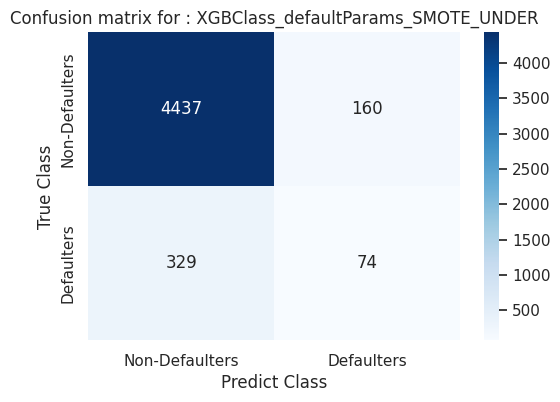

In [64]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_s_train_SMOTE_UNDER,
                                X_s_val,
                                y_s_train_SMOTE_UNDER,
                                y_s_val,
                                df_results,
                                'XGBClass_defaultParams_SMOTE_UNDER')


In [65]:
log_mlflow(XGBClass, "XGBClass_defaultParams_SMOTE_UNDER",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

[19:40:58] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:41:09] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:41:29] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:41:39] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:41:49] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:41:58] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:42:08] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:42:18] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:42:28] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:42:38] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
XGBClass_defaultParams_classWeight,0.598591,0.612903,0.116290,0.593400,0.195489,0.330567,0.526437,0.588040,0.654035,0.148195,0 days 00:00:11.493964,0 days 00:00:11.523703,2720,1877,156,247,0.997250,0.000281,0.665474,0.017843,1.000000,0.000000,0.595188,0.030815,0.251022,0.008617,0.124585,0.006252


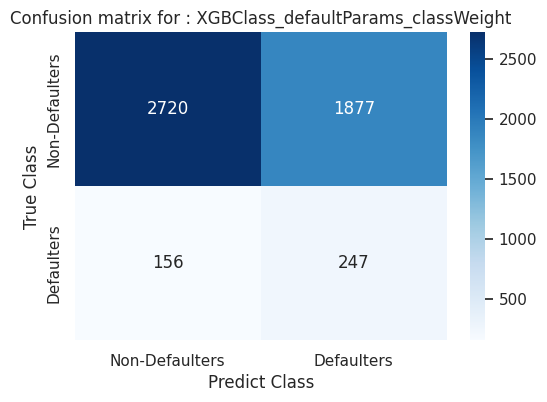

In [66]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = balance_method_analysis(XGBClass_cw,
                                           X_s_train,
                                           X_s_val,
                                           y_s_train,
                                           y_s_val,
                                           df_results,
                            'XGBClass_defaultParams_classWeight')


In [67]:
log_mlflow(XGBClass_cw, "XGBClass_defaultParams_classWeight",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

<a id='rebalancing_LightGBM'></a>

### <span style='background:#0075bc'><span style='color:white'>LightGBM</span></span>

In [68]:
# Without data balance
LGBM = ltb.LGBMClassifier(random_state = seed)

# Using class_weight
LGBM_cw = ltb.LGBMClassifier(class_weight = 'balanced',
                                         random_state = seed)

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
LGBM_defaultParams_unbalanced,0.688853,0.057072,0.433962,0.918000,0.100877,0.069069,0.059044,0.057567,0.768018,0.246220,0 days 00:00:02.533788,0 days 00:00:02.551367,4567,30,380,23,0.997187,0.000500,0.771008,0.010020,0.610045,0.008367,0.055172,0.018861,0.999547,0.000754,0.461826,0.126861


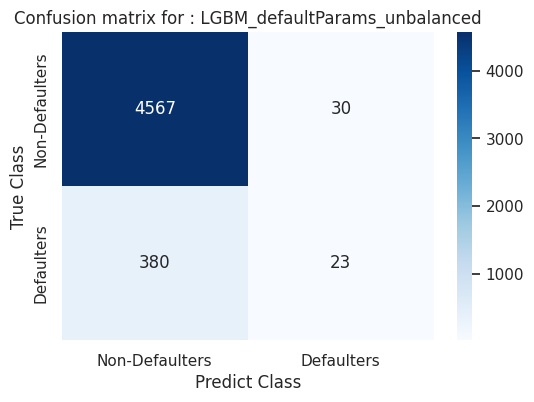

In [69]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_s_train, X_s_val, y_s_train, y_s_val,
                                df_results,
                                'LGBM_defaultParams_unbalanced')

In [70]:
log_mlflow(LGBM, "LGBM_defaultParams_unbalanced",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
LGBM_defaultParams_SMOTE,0.686285,0.049628,0.392157,0.917200,0.088106,0.060132,0.051353,0.050061,0.765537,0.230251,0 days 00:00:03.322010,0 days 00:00:03.339573,4566,31,383,20,0.997744,0.000758,0.978920,0.063191,0.939915,0.020038,0.911745,0.262951,0.999405,0.000257,0.994275,0.003142


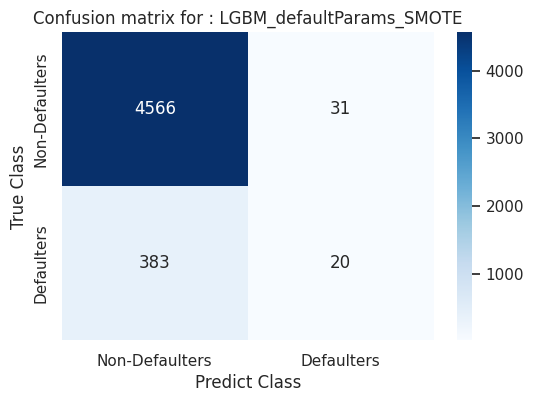

In [71]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_s_train_SMOTE, X_s_val,
                                y_s_train_SMOTE, y_s_val,
                                df_results,
                                'LGBM_defaultParams_SMOTE')


In [72]:
log_mlflow(LGBM, "LGBM_defaultParams_SMOTE",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
LGBM_defaultParams_SMOTE_UNDER,0.708887,0.168734,0.325359,0.904800,0.222222,0.186711,0.171918,0.169543,0.763638,0.237708,0 days 00:00:02.893114,0 days 00:00:02.910759,4456,141,335,68,0.998092,0.000880,0.965262,0.070332,0.940885,0.013840,0.838303,0.327918,0.998154,0.000998,0.957436,0.022044


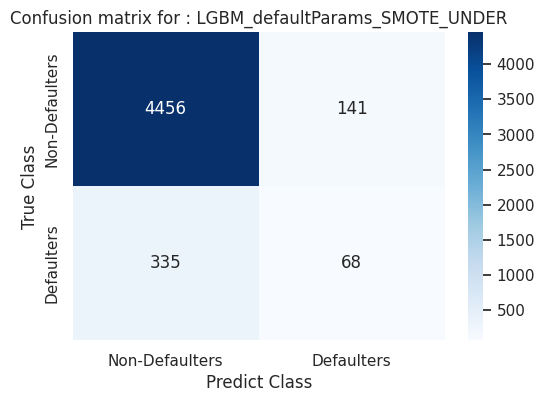

In [73]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_s_train_SMOTE_UNDER,
                                X_s_val,
                                y_s_train_SMOTE_UNDER,
                                y_s_val,
                                df_results,
                                'LGBM_defaultParams_SMOTE_UNDER')


In [74]:
log_mlflow(LGBM, "LGBM_defaultParams_SMOTE_UNDER",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,AP_SCORE,Train runtime,Train+Validatin runtime,TN,FP,FN,TP,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
LGBM_defaultParams_classWeight,0.741543,0.454094,0.249319,0.845800,0.321900,0.390026,0.440189,0.450431,0.764167,0.242517,0 days 00:00:02.170385,0 days 00:00:02.189639,4046,551,220,183,0.995034,0.000288,0.763407,0.009444,0.995660,0.001632,0.437639,0.035051,0.539461,0.007086,0.249482,0.011859


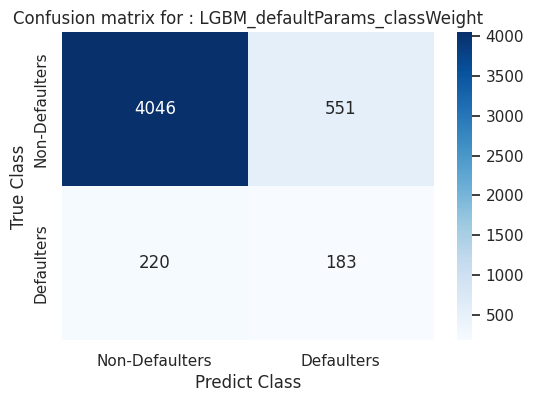

In [75]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, bussines_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM_cw,
                                X_s_train,
                                X_s_val,
                                y_s_train,
                                y_s_val,
                                df_results,
                                'LGBM_defaultParams_classWeight')


In [76]:
log_mlflow(LGBM_cw, "LGBM_defaultParams_classWeight",
           Bussines_Metric=bussines_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_s_train)[0],
           train_class_1=Counter(y_s_train)[1])

<a id='rebalancing_model_tests_summary'></a>

## <span style='background:#0085dd'><span style='color:white'>Summary</span></span>

In [77]:
# True numbers of defaulers and non-defaulters
y_s_val_counter

Counter({1: 403, 0: 4597})

* Number of defaulters 4965 (TP)
* Number of non-defaulters 56538 (TN)

In [78]:
# Define the folder containing the files with the project data
P7_scoring_credit = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/"

os.chdir(P7_scoring_credit)

In [79]:
# Load de table
file_df_result_score = 'model_tests/df_results_scores.pkl'
with open(file_df_result_score, 'rb') as f:
    df_results = pickle.load(f)

In [87]:
df_results.sort_values(by='Accuracy', ascending=False)

,Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,...,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
0,RForestClass_defaultParams_unbalanced,0.676304,0.004963,1.000000,0.9198,0.009877,0.006196,0.005160,0.005012,0.748234,...,0.737288,0.017639,0.998898,0.000631,0.004954,0.005394,1.000000,0.000000,0.466667,0.476095
0,dummy_class_defaultParams_unbalanced,0.674690,0.000000,0.000000,0.9194,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,dummy_class_defaultParams_SMOTE,0.674690,0.000000,0.000000,0.9194,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.500000,0.000000,0.300000,0.458258,0.300000,0.458258,0.150005,0.229136,0.149959,0.229066
0,dummy_class_defaultParams_SMOTE_UNDER,0.674690,0.000000,0.000000,0.9194,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.500000,0.000000,0.300000,0.458258,0.300000,0.458258,0.150009,0.229143,0.149918,0.229004
0,dummy_class_defaultParams_SMOTE,0.674690,0.000000,0.000000,0.9194,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.500000,0.000000,0.300000,0.458258,0.300000,0.458258,0.150005,0.229136,0.149959,0.229066
0,logistic_regression_defaultParams_unbalanced,0.674543,0.000000,0.000000,0.9192,0.000000,0.000000,0.000000,0.000000,0.458921,...,0.475490,0.015015,0.002549,0.000976,0.001238,0.002477,0.237396,0.068079,0.075000,0.160078
0,RForestClass_defaultParams_classWeight,0.674543,0.000000,0.000000,0.9192,0.000000,0.000000,0.000000,0.000000,0.737406,...,0.746092,0.008125,0.999105,0.000538,0.003719,0.004115,1.000000,0.000000,0.233333,0.249444
0,RForestClass_defaultParams_SMOTE,0.677625,0.014888,0.315789,0.9180,0.028436,0.018394,0.015455,0.015030,0.735052,...,0.993023,0.020856,1.000000,0.000000,0.922458,0.228460,1.000000,0.000000,0.996102,0.002891
0,LGBM_defaultParams_unbalanced,0.688853,0.057072,0.433962,0.9180,0.100877,0.069069,0.059044,0.057567,0.768018,...,0.771008,0.010020,0.610045,0.008367,0.055172,0.018861,0.999547,0.000754,0.461826,0.126861
0,LGBM_defaultParams_SMOTE,0.686285,0.049628,0.392157,0.9172,0.088106,0.060132,0.051353,0.050061,0.765537,...,0.978920,0.063191,0.939915,0.020038,0.911745,0.262951,0.999405,0.000257,0.994275,0.003142


In [88]:
df_results = df_results.sort_values(by='Bussines_score', ascending=False)
df_results.head(15)

,Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,...,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
0,LGBM_defaultParams_classWeight,0.741543,0.454094,0.249319,0.8458,0.321900,0.390026,0.440189,0.450431,0.764167,...,0.763407,0.009444,0.995660,0.001632,0.437639,0.035051,0.539461,0.007086,0.249482,0.011859
0,XGBClass_defaultParams_SMOTE_UNDER,0.710942,0.183623,0.316239,0.9022,0.232339,0.200433,0.186633,0.184388,0.734781,...,0.964740,0.070423,0.997268,0.001477,0.843634,0.317121,1.000000,0.000000,0.943131,0.028631
0,LGBM_defaultParams_SMOTE_UNDER,0.708887,0.168734,0.325359,0.9048,0.222222,0.186711,0.171918,0.169543,0.763638,...,0.965262,0.070332,0.940885,0.013840,0.838303,0.327918,0.998154,0.000998,0.957436,0.022044
0,XGBClass_defaultParams_SMOTE,0.696412,0.094293,0.383838,0.9148,0.151394,0.111046,0.097110,0.095002,0.738049,...,0.977665,0.066979,0.992519,0.002633,0.912289,0.263132,0.999988,0.000024,0.986295,0.005233
0,RForestClass_defaultParams_SMOTE_UNDER,0.695751,0.111663,0.302013,0.9076,0.163043,0.127768,0.114437,0.112364,0.736680,...,0.978296,0.043010,1.000000,0.000000,0.868663,0.259548,1.000000,0.000000,0.968076,0.009054
0,XGBClass_defaultParams_unbalanced,0.690027,0.066998,0.380282,0.9160,0.113924,0.080214,0.069190,0.067548,0.746448,...,0.742329,0.009955,0.965972,0.006487,0.071946,0.027715,1.000000,0.000000,0.436846,0.124826
0,LGBM_defaultParams_unbalanced,0.688853,0.057072,0.433962,0.9180,0.100877,0.069069,0.059044,0.057567,0.768018,...,0.771008,0.010020,0.610045,0.008367,0.055172,0.018861,0.999547,0.000754,0.461826,0.126861
0,LGBM_defaultParams_SMOTE,0.686285,0.049628,0.392157,0.9172,0.088106,0.060132,0.051353,0.050061,0.765537,...,0.978920,0.063191,0.939915,0.020038,0.911745,0.262951,0.999405,0.000257,0.994275,0.003142
0,RForestClass_defaultParams_SMOTE,0.677625,0.014888,0.315789,0.9180,0.028436,0.018394,0.015455,0.015030,0.735052,...,0.993023,0.020856,1.000000,0.000000,0.922458,0.228460,1.000000,0.000000,0.996102,0.002891
0,RForestClass_defaultParams_unbalanced,0.676304,0.004963,1.000000,0.9198,0.009877,0.006196,0.005160,0.005012,0.748234,...,0.737288,0.017639,0.998898,0.000631,0.004954,0.005394,1.000000,0.000000,0.466667,0.476095


In [89]:
# We are looking for the lowest rate of FN
df_results = df_results.sort_values(by='FN', ascending=True)
df_results.head(10)

,Experience,Bussines_score,Recall,Precision,Accuracy,F1,F2,F5,F10,ROC_AUC,...,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
0,logistic_regression_defaultParams_classWeight,0.508916,0.632754,0.091496,0.4640,0.159875,0.289839,0.515472,0.597744,0.575133,...,0.563747,0.031565,0.624579,0.010676,0.613101,0.048361,0.090163,0.000804,0.088813,0.006687
0,logistic_regression_defaultParams_SMOTE,0.523299,0.612903,0.093667,0.4908,0.162500,0.290657,0.505192,0.581014,0.574346,...,0.578672,0.009720,0.608661,0.006374,0.609233,0.014480,0.538764,0.001086,0.539670,0.007886
0,XGBClass_defaultParams_classWeight,0.598591,0.612903,0.116290,0.5934,0.195489,0.330567,0.526437,0.588040,0.654035,...,0.665474,0.017843,1.000000,0.000000,0.595188,0.030815,0.251022,0.008617,0.124585,0.006252
0,logistic_regression_defaultParams_SMOTE_UNDER,0.520070,0.593052,0.091676,0.4936,0.158804,0.283242,0.489986,0.562589,0.573321,...,0.574306,0.012924,0.603043,0.005950,0.601978,0.017542,0.540247,0.001348,0.540097,0.008405
0,LGBM_defaultParams_classWeight,0.741543,0.454094,0.249319,0.8458,0.321900,0.390026,0.440189,0.450431,0.764167,...,0.763407,0.009444,0.995660,0.001632,0.437639,0.035051,0.539461,0.007086,0.249482,0.011859
0,XGBClass_defaultParams_SMOTE_UNDER,0.710942,0.183623,0.316239,0.9022,0.232339,0.200433,0.186633,0.184388,0.734781,...,0.964740,0.070423,0.997268,0.001477,0.843634,0.317121,1.000000,0.000000,0.943131,0.028631
0,LGBM_defaultParams_SMOTE_UNDER,0.708887,0.168734,0.325359,0.9048,0.222222,0.186711,0.171918,0.169543,0.763638,...,0.965262,0.070332,0.940885,0.013840,0.838303,0.327918,0.998154,0.000998,0.957436,0.022044
0,RForestClass_defaultParams_SMOTE_UNDER,0.695751,0.111663,0.302013,0.9076,0.163043,0.127768,0.114437,0.112364,0.736680,...,0.978296,0.043010,1.000000,0.000000,0.868663,0.259548,1.000000,0.000000,0.968076,0.009054
0,XGBClass_defaultParams_SMOTE,0.696412,0.094293,0.383838,0.9148,0.151394,0.111046,0.097110,0.095002,0.738049,...,0.977665,0.066979,0.992519,0.002633,0.912289,0.263132,0.999988,0.000024,0.986295,0.005233
0,XGBClass_defaultParams_unbalanced,0.690027,0.066998,0.380282,0.9160,0.113924,0.080214,0.069190,0.067548,0.746448,...,0.742329,0.009955,0.965972,0.006487,0.071946,0.027715,1.000000,0.000000,0.436846,0.124826


**Metrics summary**

In [90]:
experiences_list = list(df_results['Experience'])

In [91]:
experiences_list[0:5]

['logistic_regression_defaultParams_classWeight',
 'logistic_regression_defaultParams_SMOTE',
 'XGBClass_defaultParams_classWeight',
 'logistic_regression_defaultParams_SMOTE_UNDER',
 'LGBM_defaultParams_classWeight']

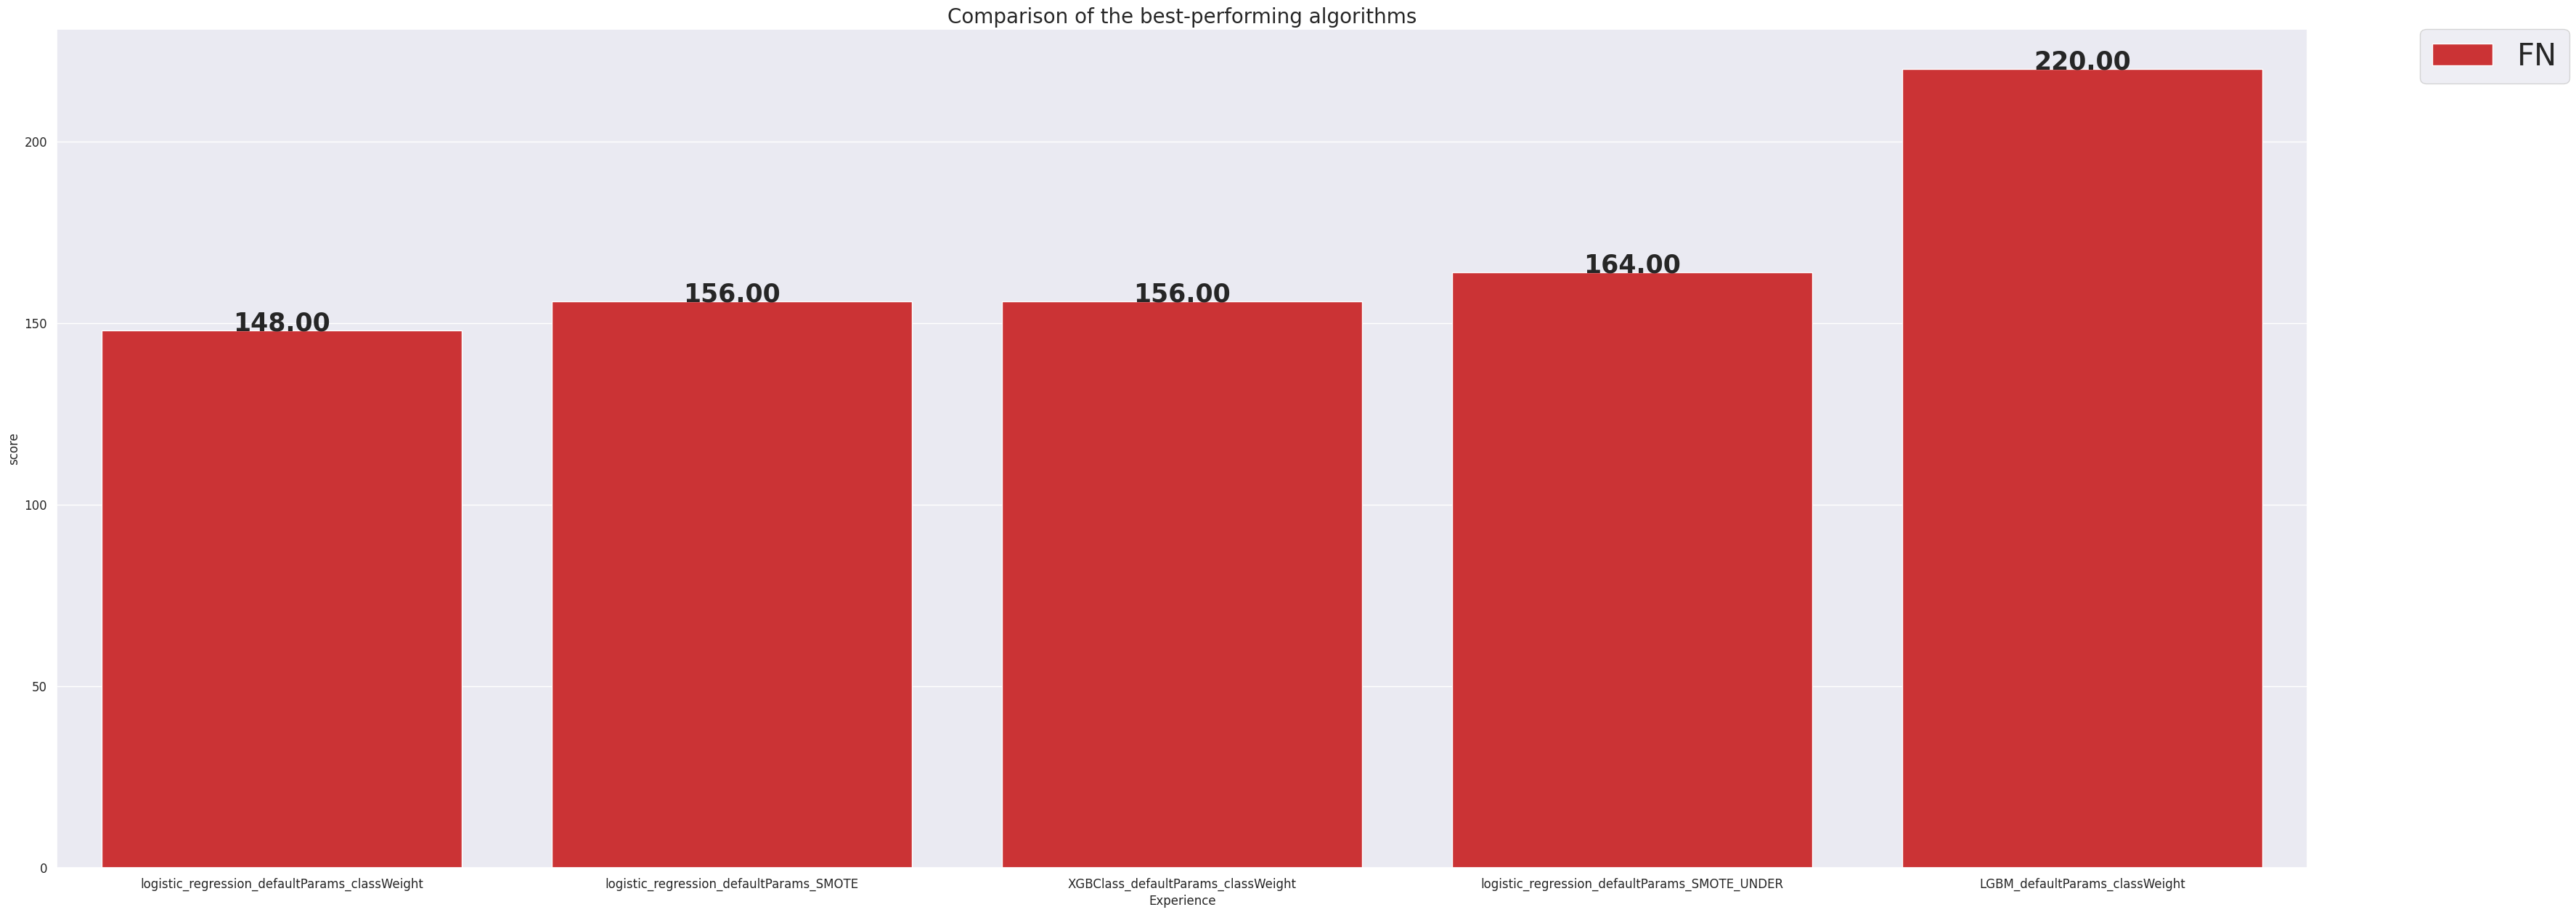

Experience,FN,Recall,Precision,F1,F5,F10,ROC_AUC,AP_SCORE,Bussines_score
logistic_regression_defaultParams_classWeight,148,0.632754,0.091496,0.159875,0.515472,0.597744,0.575133,0.109591,0.508916
logistic_regression_defaultParams_SMOTE,156,0.612903,0.093667,0.162500,0.505192,0.581014,0.574346,0.108735,0.523299
XGBClass_defaultParams_classWeight,156,0.612903,0.116290,0.195489,0.526437,0.588040,0.654035,0.148195,0.598591
logistic_regression_defaultParams_SMOTE_UNDER,164,0.593052,0.091676,0.158804,0.489986,0.562589,0.573321,0.109654,0.520070
LGBM_defaultParams_classWeight,220,0.454094,0.249319,0.321900,0.440189,0.450431,0.764167,0.242517,0.741543


In [92]:
# Visual comparison of the 5 best-performing algorithms
df_comp_results = df_results[df_results['Experience'].isin(experiences_list[0:5])]



# Scores
comparaison_score_melt = \
    pd.melt(df_comp_results, id_vars=['Experience'], value_name='score',
            value_vars=['FN'])
# Visualization
plt.figure(figsize=(40, 15))
ax= sns.barplot(x=comparaison_score_melt['Experience'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=25,
            fontweight='bold') 
plt.show()

df_comp_results[['Experience', 'FN', 'Recall', 'Precision',
                 'F1', 'F5', 'F10',
                 'ROC_AUC', 'AP_SCORE',
                 'Bussines_score']].style.hide(axis="index")

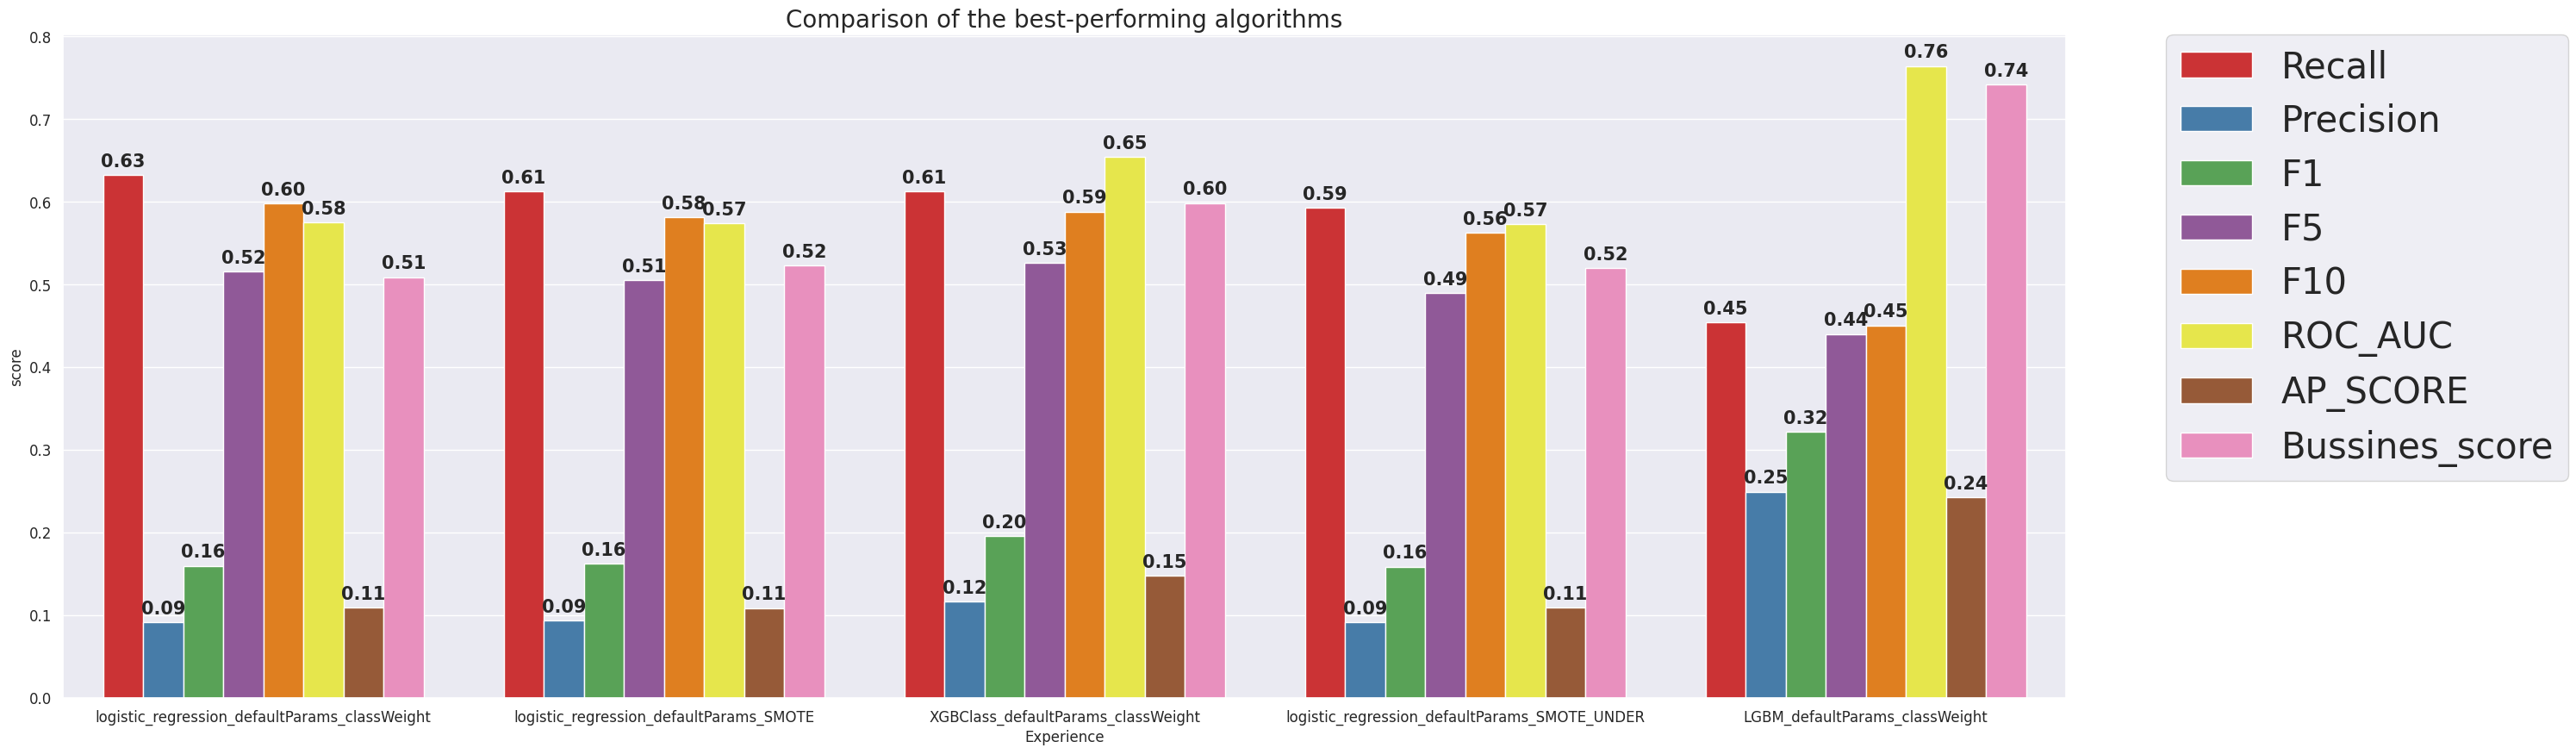

Experience,Recall,Precision,F1,F5,F10,ROC_AUC,AP_SCORE,Bussines_score
logistic_regression_defaultParams_classWeight,0.632754,0.091496,0.159875,0.515472,0.597744,0.575133,0.109591,0.508916
logistic_regression_defaultParams_SMOTE,0.612903,0.093667,0.162500,0.505192,0.581014,0.574346,0.108735,0.523299
XGBClass_defaultParams_classWeight,0.612903,0.116290,0.195489,0.526437,0.588040,0.654035,0.148195,0.598591
logistic_regression_defaultParams_SMOTE_UNDER,0.593052,0.091676,0.158804,0.489986,0.562589,0.573321,0.109654,0.520070
LGBM_defaultParams_classWeight,0.454094,0.249319,0.321900,0.440189,0.450431,0.764167,0.242517,0.741543


In [95]:
# Visual comparison of the 5 best-performing algorithms
df_comp_results = df_results[df_results['Experience'].isin(experiences_list[0:5])]



# Scores
comparaison_score_melt = \
    pd.melt(df_comp_results, id_vars=['Experience'], value_name='score',
            value_vars=['Recall', 'Precision', 'F1', 'F5', 'F10',
                        'ROC_AUC', 'AP_SCORE', 'Bussines_score'])
# Visualization
plt.figure(figsize=(30, 10))
ax= sns.barplot(x=comparaison_score_melt['Experience'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=15,
            fontweight='bold') 
plt.show()

df_comp_results[['Experience', 'Recall', 'Precision',
                 'F1', 'F5', 'F10',
                 'ROC_AUC', 'AP_SCORE',
                 'Bussines_score']].style.hide(axis="index")

<a id='model_selection'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Model selection** </span></span>


<a id='hyperparameter_optimization'></a>

## <span style='background:#0085dd'><span style='color:white'>Hyperparameter optimization</span></span>

Para optimizar y evaluar los modelos
* Primero hay busqueda de los hiperparametros optimos via validacion cruzada. (search_best_model)<br>
* Para comprender mejor la relacion entre los hiperparametros de los alogrithmos y los scorers para evaluar los modelos se hace una representacion grafica (plot_best_param_scores)<br>
* Para facilitar la comparacion entre los mejores resultados de los modelos, se crea una tabla para almacenar los datos (add_model_score)<br>
* Se fit el algorithmo usando los best_params sobre los datos de train y se hace la prediccion usando predict_proba (train_best_params)<br>
* A traves de una nueva funcion se identifica el umbral de probabilidad que optimiza los scorers (calc_threshold_scores)<br>
* Se generan varias graficas de sintesis para facilitar la evaluacion de la performance del modelo


In [73]:
target_counter = Counter(train_data.TARGET)
print("Number of entries:", target_counter)

# Print ratio
print("Target ratio in training dataset is 1:{:.0f}".format(target_counter[0] / target_counter[1]))

Number of entries: Counter({0: 282686, 1: 24825})
Target ratio in training dataset is 1:11


In [74]:
# The following method was used to create a sub-dataset  :
#train_data_opti = train_data.loc[np.random.choice(train_data.index, 5000, replace=False)]

#To use a stable dataset, I saved the one generated by the method described above.
path_sav_opti_train = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/reduced_train_opti.pkl'

# with open(path_sav_opti_train, 'wb') as f:
#     pickle.dump(train_data_opti, f, pickle.HIGHEST_PROTOCOL)

# Upload the reduced dataset
with open(path_sav_opti_train, 'rb') as f:
    train_data_opti = pickle.load(f)

In [75]:
opti_target_counter = Counter(train_data_opti.TARGET)
print("Number of entries:", opti_target_counter)

# Print ratio
print("Target ratio in the reduced training dataset for optimisation is 1:{:.0f}".format(opti_target_counter[0] / opti_target_counter[1]))

Number of entries: Counter({0: 4586, 1: 414})
Target ratio in the reduced training dataset for optimisation is 1:11


In [76]:
# Define target
y_opti = train_data_opti.pop('TARGET')
print(f'y_opti : {y_opti.shape}')

# Transfer of the customer identifier to the index for modelling purposes
train_data_opti.set_index('SK_ID_CURR', inplace=True)
X_opti = train_data_opti
print(f'X_opti : {X_opti.shape}')


y_opti : (5000,)
X_opti : (5000, 488)


In [77]:
# Split dataset (filled)
X_o_train, X_o_val, y_o_train, y_o_val = train_test_split(X_opti, y_opti,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y_opti,
                                                  random_state=seed)

In [78]:
# transform the dataset
oversample = SMOTE()

# transform the dataset
X_o_train_SMOTE, y_o_train_SMOTE = oversample.fit_resample(X_o_train, y_o_train)
X_o_val_SMOTE, y_o_val_SMOTE = oversample.fit_resample(X_o_val, y_o_val)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f75355c2820>
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<loc

In [79]:
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline_under = imbpipeline.Pipeline(steps=steps)

# transform the dataset
X_o_train_SMOTE_UNDER, y_o_train_SMOTE_UNDER = pipeline_under.fit_resample(X_o_train, y_o_train)

X_o_val_SMOTE_UNDER, y_o_val_SMOTE_UNDER = pipeline_under.fit_resample(X_o_val, y_o_val)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f75d41bba60>
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<loc

In [80]:
df_temp.columns

Index(['Experience', 'recall', 'precision', 'accuracy', 'f1_score', 'f2_score',
       'f5_score', 'f10_score', 'bussines_metric', 'tn', 'fp', 'fn', 'tp',
       'roc_auc', 'ap_score'],
      dtype='object')

In [81]:
# Create a table for recording models scores

# Columns definition
metrics_columns = list(df_temp.columns)
metrics_columns.remove('Experience')
cols = ['Experience', 'params', 'train_time',
        'gridsearch_time'] + metrics_columns

df_scores_models = pd.DataFrame(columns=cols)

In [82]:
df_scores_models

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,f10_score,bussines_metric,tn,fp,fn,tp,roc_auc,ap_score


<a id='optimization_dummy'></a>

### <span style='background:#0075bc'><span style='color:white'>Baseline : Dummy Classifier</span></span>

In [84]:
DC = DummyClassifier(strategy='most_frequent', random_state=seed)

Experience = 'Baseline (Dummy)'
param_grid = {}
dummy_pipeline = imbpipeline.Pipeline(steps=[('clf', DC)])

dummy_pipeline

Pipeline(steps=[('clf',
                 DummyClassifier(random_state=84, strategy='most_frequent'))])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV took 0.076 s
Best Parameters: {}
Best Train Score (roc_auc) : 0.500
Best Test Score (roc_auc): 0.500
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Baseline (Dummy); training time = 0.007019567489624024 s; estimated gridsearch time (5 splits) = 0.051 s
add_model_score, model = Baseline (Dummy)
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.917, 'f1_score': 0.0, 'f2_score': 0.0, 'f5_score': 0.0, 'f10_score': 0.0, 'bussines_metric': 0.668, 'tn': 917, 'fp': 0, 'fn': 83, 'tp': 0, 'roc_auc': 0.5, 'ap_score': 0.083}
Plotting results for Baseline (Dummy) with best_params : {}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       917
           1       0.00      0.00      0.00        83

    accuracy                           0.92      1000
   macro avg       0.46      0.50      0.48      1000
weighted avg      

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this b

best threshold for roc_auc : 0.100 (score = 0.500)
best threshold for f2_score : 0.100 (score = 0.000)
best threshold for bussines_metric : 0.100 (score = 0.668)
Best Threshold=1.000, Youden J =0.000
Best Threshold=0.000, F-Score=0.153


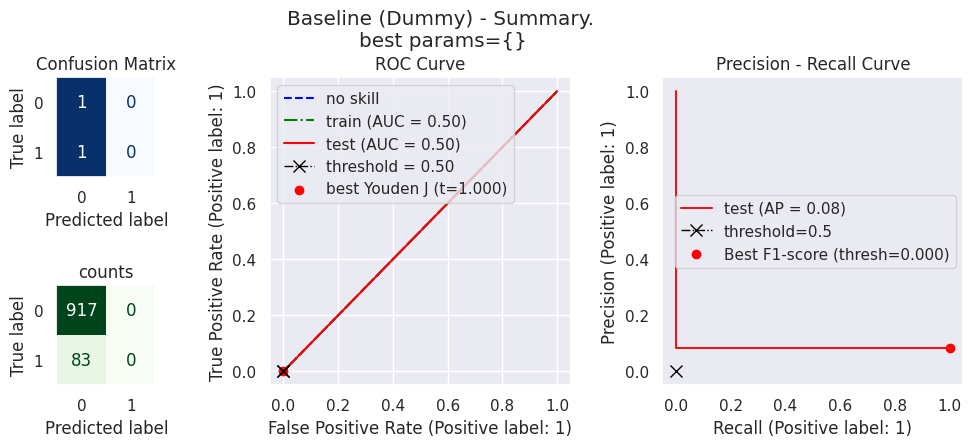

In [85]:
evaluate_model(Experience, dummy_pipeline,
                              X_o_train, y_o_train,
                              X_o_val, y_o_val)

In [86]:
dummy_opt = df_scores_models.loc[df_scores_models["Experience"] == "Baseline (Dummy)"]
dummy_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
0,Baseline (Dummy),{},0.0,0.051,0.0,0.0,0.917,0.0,0.0,0.0,...,0.0,0.668369,0.001457,0.668367,0.000365,0.0,0.0,0.0,0.0,0.5


In [87]:
log_mlflow(dummy_pipeline, "dummy_class_opti_unbalanced",
           Bussines_Metric=dummy_opt.bussines_metric,
           Recall=dummy_opt.recall,
           Precision=dummy_opt.precision,
           Accuracy=dummy_opt.accuracy,
           F1_score=dummy_opt.f1_score, F2_score=dummy_opt.f2_score,
           F5_score=dummy_opt.f5_score, F10_score=dummy_opt.f10_score,
           Roc_auc=dummy_opt.roc_auc,
           AP_score=dummy_opt.ap_score,
           TN= dummy_opt.tn, FP=dummy_opt.fp,
           FN=dummy_opt.fn, TP=dummy_opt.tp,
           train_class_0=Counter(y_o_train)[0],
           train_class_1=Counter(y_o_train)[1])

<a id='optimization_LogisticRegression'></a>

### <span style='background:#0075bc'><span style='color:white'>Logistic regression</span></span>

In [88]:
# X_o_train_SMOTE, y_o_train_SMOTE
# X_o_val_SMOTE, y_o_val_SMOTE

Experience = 'LogisticRegression_smote'
LR_pipeline = imbpipeline.Pipeline(steps=[
    ('clf', LogisticRegression(random_state=seed)),
])
param_grid = {
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver':['liblinear']
}

LR_pipeline

Pipeline(steps=[('clf', LogisticRegression(random_state=84))])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.

5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits faile

GridSearchCV took 2286.833 s
Best Parameters: {'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best Train Score (roc_auc) : 0.967
Best Test Score (roc_auc): 0.938


Liblinear failed to converge, increase the number of iterations.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LogisticRegression_smote; training time = 118.29639663696291 s; estimated gridsearch time (15 splits) = 1774.758 s
add_model_score, model = LogisticRegression_smote
{'recall': 0.672, 'precision': 0.827, 'accuracy': 0.766, 'f1_score': 0.741, 'f2_score': 0.698, 'f5_score': 0.677, 'f10_score': 0.673, 'bussines_metric': 0.701, 'tn': 788, 'fp': 129, 'fn': 301, 'tp': 616, 'roc_auc': 0.843, 'ap_score': 0.834}
Plotting results for LogisticRegression_smote with best_params : {'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


Liblinear failed to converge, increase the number of iterations.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.72      0.86      0.79       917
           1       0.83      0.67      0.74       917

    accuracy                           0.77      1834
   macro avg       0.78      0.77      0.76      1834
weighted avg       0.78      0.77      0.76      1834

1-specificity(FPR) = 0.14, sensitivity(TPR) 0.67
best threshold for roc_auc : 0.350 (score = 0.779)
best threshold for f2_score : 0.100 (score = 0.827)
best threshold for bussines_metric : 0.100 (score = 0.830)
Best Threshold=0.339, Youden J =0.564
Best Threshold=0.168, F-Score=0.785


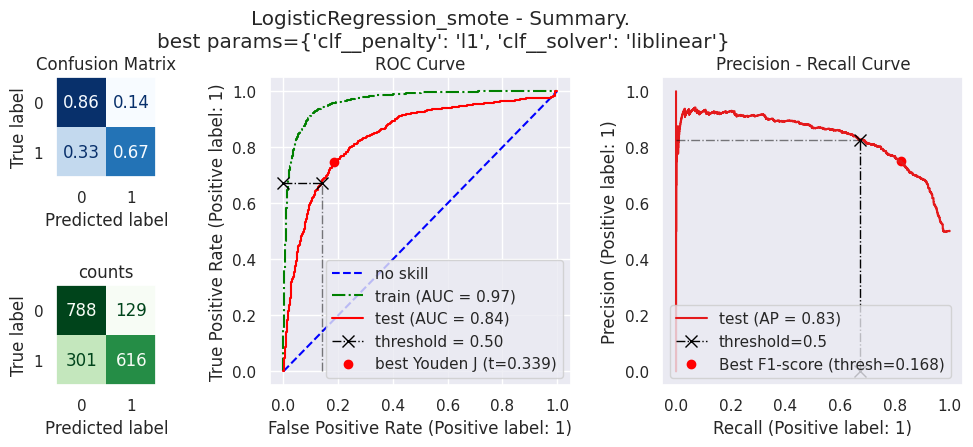

In [89]:
evaluate_model(Experience, LR_pipeline, X_o_train_SMOTE, y_o_train_SMOTE,
            X_o_val_SMOTE, y_o_val_SMOTE, param_grid)

In [90]:
LR_opt = df_scores_models.loc[df_scores_models["Experience"] == "LogisticRegression_smote"]
LR_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
1,LogisticRegression_smote,"{'clf__penalty': 'l1', 'clf__solver': 'libline...",512.34,1774.758,0.672,0.827,0.766,0.741,0.698,0.677,...,0.006009,0.887678,0.081095,0.909712,0.010504,0.885305,0.080721,0.909423,0.010451,0.5


In [91]:
log_mlflow(LR_pipeline, "logistic_regression_opti_SMOTE",
           Bussines_Metric=LR_opt.bussines_metric,
           Recall=LR_opt.recall,
           Precision=LR_opt.precision,
           Accuracy=LR_opt.accuracy,
           F1_score=LR_opt.f1_score, F2_score=LR_opt.f2_score,
           F5_score=LR_opt.f5_score, F10_score=LR_opt.f10_score,
           Roc_auc=LR_opt.roc_auc,
           AP_score=LR_opt.ap_score,
           TN=LR_opt.tn, FP=LR_opt.fp, 
           FN=LR_opt.fn, TP=LR_opt.tp,
           train_class_0=Counter(y_o_train_SMOTE)[0],
           train_class_1=Counter(y_o_train_SMOTE)[1])

<a id='optimization_RandomForest'></a>

### <span style='background:#0075bc'><span style='color:white'>Random Forest</span></span>

In [92]:

# X_o_train_SMOTE, y_o_train_SMOTE
# X_o_val_SMOTE, y_o_val_SMOTE

Experience = 'RandomForest_smote'

rfc_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('feat_select', 'passthrough'),
    ('clf', RandomForestClassifier(random_state = seed, max_features='auto'))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__criterion': ['gini', 'entropy']}

rfc_pipeline

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_features='auto', random_state=84))])

Fitting 5 folds for each of 14 candidates, totalling 70 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

GridSearchCV took 177.601 s
Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9}
Best Train Score (roc_auc) : 0.999
Best Test Score (roc_auc): 0.989


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (RandomForest_smote; training time = 2.3474468844277516 s; estimated gridsearch time (70 splits) = 167.211 s
add_model_score, model = RandomForest_smote
{'recall': 0.827, 'precision': 0.967, 'accuracy': 0.899, 'f1_score': 0.891, 'f2_score': 0.851, 'f5_score': 0.831, 'f10_score': 0.828, 'bussines_metric': 0.849, 'tn': 891, 'fp': 26, 'fn': 159, 'tp': 758, 'roc_auc': 0.962, 'ap_score': 0.97}
Plotting results for RandomForest_smote with best_params : {'clf__criterion': 'gini', 'clf__max_depth': 9}


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       917
           1       0.97      0.83      0.89       917

    accuracy                           0.90      1834
   macro avg       0.91      0.90      0.90      1834
weighted avg       0.91      0.90      0.90      1834

1-specificity(FPR) = 0.03, sensitivity(TPR) 0.83
best threshold for roc_auc : 0.450 (score = 0.905)
best threshold for f2_score : 0.250 (score = 0.912)
best threshold for bussines_metric : 0.250 (score = 0.921)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

Best Threshold=0.459, Youden J =0.812
Best Threshold=0.379, F-Score=0.904


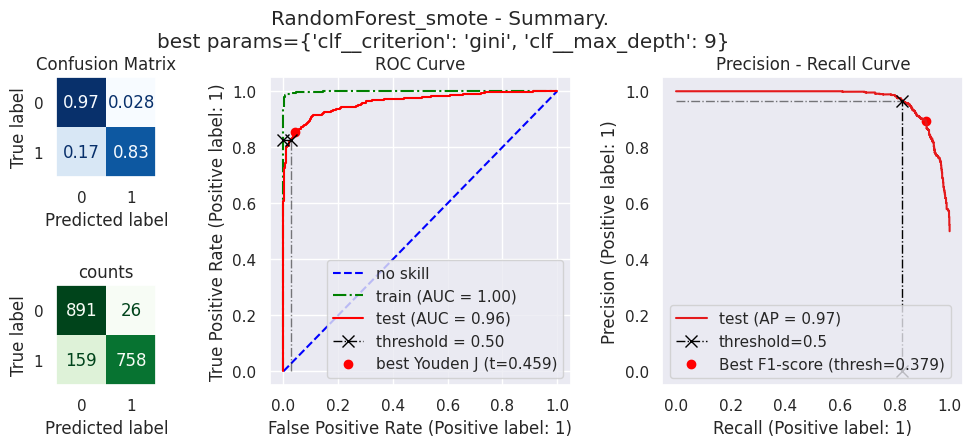

In [93]:
evaluate_model(Experience, rfc_pipeline, X_o_train_SMOTE, y_o_train_SMOTE,
            X_o_val_SMOTE, y_o_val_SMOTE, param_grid)

In [94]:
RF_opt = df_scores_models.loc[df_scores_models["Experience"] == "RandomForest_smote"]
RF_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
2,RandomForest_smote,"{'clf__criterion': 'gini', 'clf__max_depth': 9}",3.689,167.211,0.827,0.967,0.899,0.891,0.851,0.831,...,0.000369,0.937703,0.100137,0.985738,0.0064,0.936475,0.100486,0.986109,0.006134,0.5


In [95]:
log_mlflow(rfc_pipeline, "RForestClass_opti_SMOTE",
           Bussines_Metric=RF_opt.bussines_metric,
           Recall=RF_opt.recall,
           Precision=RF_opt.precision,
           Accuracy=RF_opt.accuracy,
           F1_score=RF_opt.f1_score, F2_score=RF_opt.f2_score,
           F5_score=RF_opt.f5_score, F10_score=RF_opt.f10_score,
           Roc_auc=RF_opt.roc_auc,
           AP_score=RF_opt.ap_score,
           TN=RF_opt.tn, FP=RF_opt.fp,
           FN=RF_opt.fn, TP=RF_opt.tp,
           train_class_0=Counter(y_o_train_SMOTE)[0],
           train_class_1=Counter(y_o_train_SMOTE)[1])

<a id='optimization_XGBoost'></a>

### <span style='background:#0075bc'><span style='color:white'>XG Boost</span></span>

In [96]:

# X_o_train_SMOTE, y_o_train_SMOTE
# X_o_val_SMOTE, y_o_val_SMOTE

Experience = 'XGBoost_smote'

XGBoost_pipeline = imbpipeline.Pipeline(steps=[('clf', xgb.XGBClassifier(random_state = seed))])

param_grid =  {'clf__learning_rate': [0.1, 0.01, 0.05],
               'clf__gamma': [0.5, 2, 5],
               'clf__subsample': [0.6, 1.0],
               'clf__max_depth': [4, 6]}

XGBoost_pipeline

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=84, ...))])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearchCV took 712.21 s
Best Parameters: {'clf__gamma': 0.5, 'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__subsample': 0.6}
Best Train Score (roc_auc) : 1.000
Best Test Score (roc_auc): 0.989
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (XGBoost_smote; training time = 3.8224317378467987 s; estimated gridsearch time (180 splits) = 695.338 s
add_model_score, model = XGBoost_smote
{'recall': 0.881, 'precision': 0.991, 'accuracy': 0.937, 'f1_score': 0.933, 'f2_score': 0.901, 'f5_score': 0.885, 'f10_score': 0.882, 'bussines_metric': 0.898, 'tn': 910, 'fp': 7, 'fn': 109, 'tp': 808, 'roc_auc': 0.976, 'ap_score': 0.982}
Plotting results for XGBoost_smote with best_params : {'clf__gamma': 0.5, 'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__subsample': 0.6}


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       917
           1       0.99      0.88      0.93       917

    accuracy                           0.94      1834
   macro avg       0.94      0.94      0.94      1834
weighted avg       0.94      0.94      0.94      1834

1-specificity(FPR) = 0.01, sensitivity(TPR) 0.88


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.450 (score = 0.937)
best threshold for f2_score : 0.150 (score = 0.929)
best threshold for bussines_metric : 0.150 (score = 0.934)
Best Threshold=0.436, Youden J =0.878
Best Threshold=0.436, F-Score=0.936


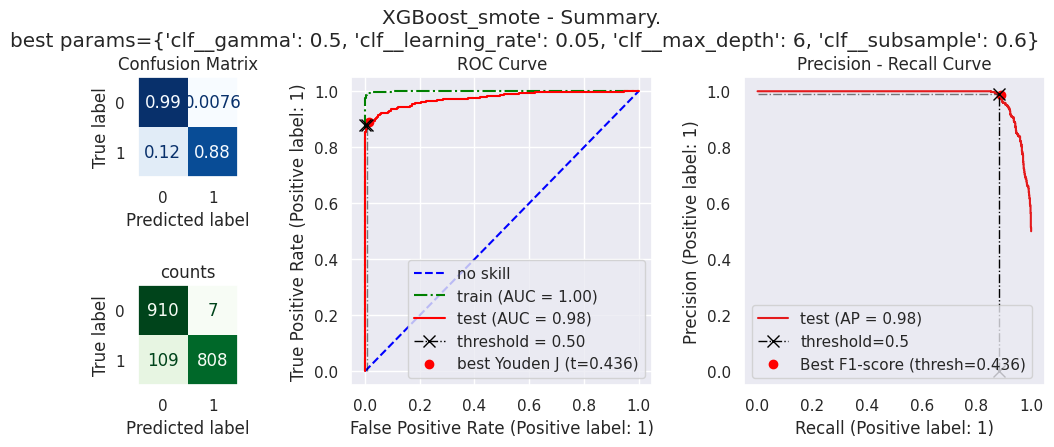

In [97]:
evaluate_model(Experience, XGBoost_pipeline, X_o_train_SMOTE, y_o_train_SMOTE,
            X_o_val_SMOTE, y_o_val_SMOTE, param_grid)

In [98]:
XGB_opt = df_scores_models.loc[df_scores_models["Experience"] == "XGBoost_smote"]
XGB_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
3,XGBoost_smote,"{'clf__gamma': 0.5, 'clf__learning_rate': 0.05...",4.73,695.338,0.881,0.991,0.937,0.933,0.901,0.885,...,0.000157,0.921651,0.1502,0.981126,0.00945,0.91833,0.155728,0.982012,0.009009,0.5


In [99]:
log_mlflow(XGBoost_pipeline, "XGBClass_opti_SMOTE",
           Bussines_Metric=XGB_opt.bussines_metric,
           Recall=XGB_opt.recall,
           Precision=XGB_opt.precision,
           Accuracy=XGB_opt.accuracy,
           F1_score=XGB_opt.f1_score, F2_score=XGB_opt.f2_score,
           F5_score=XGB_opt.f5_score, F10_score=XGB_opt.f10_score,
           Roc_auc=XGB_opt.roc_auc,
           AP_score=XGB_opt.ap_score,
           TN=XGB_opt.tn, FP=XGB_opt.fp,
           FN=XGB_opt.fn, TP=XGB_opt.tp,
           train_class_0=Counter(y_o_train_SMOTE)[0],
           train_class_1=Counter(y_o_train_SMOTE)[1])

<a id='roptimization_LightGBM'></a>

### <span style='background:#0075bc'><span style='color:white'>LightGBM</span></span>

In [100]:

# X_o_train_SMOTE, y_o_train_SMOTE
# X_o_val_SMOTE, y_o_val_SMOTE

Experience = 'LGBM_smote'

LGBM_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(random_state = seed))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__min_child_samples': [50]}

LGBM_pipeline

Pipeline(steps=[('clf', LGBMClassifier(random_state=84))])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV took 41.138 s
Best Parameters: {'clf__max_depth': 9, 'clf__min_child_samples': 50}
Best Train Score (roc_auc) : 1.000
Best Test Score (roc_auc): 0.990
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_smote; training time = 1.0438182217734198 s; estimated gridsearch time (35 splits) = 37.139 s
add_model_score, model = LGBM_smote
{'recall': 0.889, 'precision': 0.993, 'accuracy': 0.941, 'f1_score': 0.938, 'f2_score': 0.908, 'f5_score': 0.892, 'f10_score': 0.89, 'bussines_metric': 0.905, 'tn': 911, 'fp': 6, 'fn': 102, 'tp': 815, 'roc_auc': 0.977, 'ap_score': 0.983}
Plotting results for LGBM_smote with best_params : {'clf__max_depth': 9, 'clf__min_child_samples': 50}


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       917
           1       0.99      0.89      0.94       917

    accuracy                           0.94      1834
   macro avg       0.95      0.94      0.94      1834
weighted avg       0.95      0.94      0.94      1834

1-specificity(FPR) = 0.01, sensitivity(TPR) 0.89


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.400 (score = 0.946)
best threshold for f2_score : 0.150 (score = 0.931)
best threshold for bussines_metric : 0.150 (score = 0.932)
Best Threshold=0.338, Youden J =0.895
Best Threshold=0.338, F-Score=0.946


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


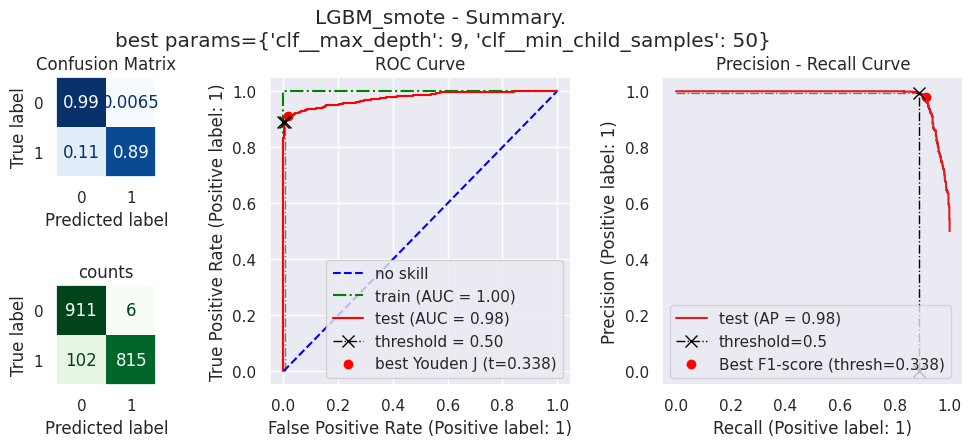

In [101]:
evaluate_model(Experience, LGBM_pipeline, X_o_train_SMOTE, y_o_train_SMOTE,
            X_o_val_SMOTE, y_o_val_SMOTE, param_grid)

In [102]:
LGBM_S_opt = df_scores_models.loc[df_scores_models["Experience"] == "LGBM_smote"]
LGBM_S_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
4,LGBM_smote,"{'clf__max_depth': 9, 'clf__min_child_samples'...",1.168,37.139,0.889,0.993,0.941,0.938,0.908,0.892,...,0.0,0.922175,0.151876,1.0,0.0,0.918737,0.157633,1.0,0.0,0.5


In [103]:
log_mlflow(LGBM_pipeline, "LGBM_opt_SMOTE",
           Bussines_Metric=LGBM_S_opt.bussines_metric,
           Recall=LGBM_S_opt.recall,
           Precision=LGBM_S_opt.precision,
           Accuracy=LGBM_S_opt.accuracy,
           F1_score=LGBM_S_opt.f1_score, F2_score=LGBM_S_opt.f2_score,
           F5_score=LGBM_S_opt.f5_score, F10_score=LGBM_S_opt.f10_score,
           Roc_auc=LGBM_S_opt.roc_auc,
           AP_score=LGBM_S_opt.ap_score,
           TN=LGBM_S_opt.tn, FP=LGBM_S_opt.fp,
           FN=LGBM_S_opt.fn, TP=LGBM_S_opt.tp,
           train_class_0=Counter(y_o_train_SMOTE)[0],
           train_class_1=Counter(y_o_train_SMOTE)[1])

In [104]:

# X_o_train_SMOTE_UNDER, y_o_train_SMOTE_UNDER
# X_o_val_SMOTE_UNDER, y_o_val_SMOTE_UNDER

Experience = 'LGBM_smote_under'

LGBM_SU_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(random_state = seed))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__min_child_samples': [50]}

LGBM_SU_pipeline

Pipeline(steps=[('clf', LGBMClassifier(random_state=84))])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV took 21.836 s
Best Parameters: {'clf__max_depth': 7, 'clf__min_child_samples': 50}
Best Train Score (roc_auc) : 1.000
Best Test Score (roc_auc): 0.974
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_smote_under; training time = 0.5641625608716693 s; estimated gridsearch time (35 splits) = 20.233 s
add_model_score, model = LGBM_smote_under
{'recall': 0.812, 'precision': 0.951, 'accuracy': 0.885, 'f1_score': 0.876, 'f2_score': 0.837, 'f5_score': 0.817, 'f10_score': 0.813, 'bussines_metric': 0.835, 'tn': 439, 'fp': 19, 'fn': 86, 'tp': 372, 'roc_auc': 0.951, 'ap_score': 0.961}
Plotting results for LGBM_smote_under with best_params : {'clf__max_depth': 7, 'clf__min_child_samples': 50}


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       458
           1       0.95      0.81      0.88       458

    accuracy                           0.89       916
   macro avg       0.89      0.89      0.88       916
weighted avg       0.89      0.89      0.88       916

1-specificity(FPR) = 0.04, sensitivity(TPR) 0.81
best threshold for roc_auc : 0.350 (score = 0.891)
best threshold for f2_score : 0.150 (score = 0.893)
best threshold for bussines_metric : 0.150 (score = 0.897)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

Best Threshold=0.379, Youden J =0.788
Best Threshold=0.334, F-Score=0.891


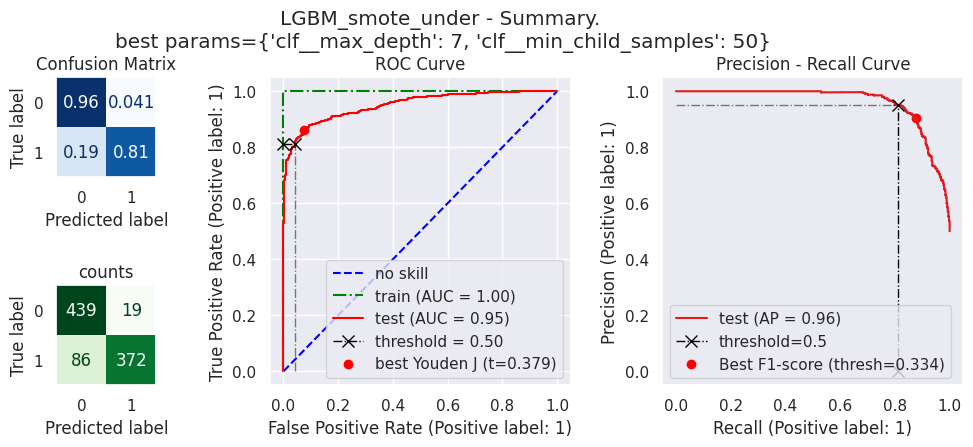

In [105]:
evaluate_model(Experience, LGBM_SU_pipeline,
               X_o_train_SMOTE_UNDER, y_o_train_SMOTE_UNDER,
               X_o_val_SMOTE_UNDER, y_o_val_SMOTE_UNDER, param_grid)

In [106]:
LGBM_SU_opt = df_scores_models.loc[df_scores_models["Experience"] == "LGBM_smote_under"]
LGBM_SU_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
5,LGBM_smote_under,"{'clf__max_depth': 7, 'clf__min_child_samples'...",0.645,20.233,0.812,0.951,0.885,0.876,0.837,0.817,...,0.0,0.841748,0.300145,0.999885,0.000231,0.816816,0.345328,0.999891,0.000218,0.5


In [107]:
log_mlflow(LGBM_SU_pipeline, "LGBM_opt_SMOTE_UNDER",
           Bussines_Metric=LGBM_SU_opt.bussines_metric,
           Recall=LGBM_SU_opt.recall,
           Precision=LGBM_SU_opt.precision,
           Accuracy=LGBM_SU_opt.accuracy,
           F1_score=LGBM_SU_opt.f1_score, F2_score=LGBM_SU_opt.f2_score,
           F5_score=LGBM_SU_opt.f5_score, F10_score=LGBM_SU_opt.f10_score,
           Roc_auc=LGBM_SU_opt.roc_auc,
           AP_score=LGBM_SU_opt.ap_score,
           TN=LGBM_SU_opt.tn, FP=LGBM_SU_opt.fp,
           FN=LGBM_SU_opt.fn, TP=LGBM_SU_opt.tp,
           train_class_0=Counter(y_o_train_SMOTE_UNDER)[0],
           train_class_1=Counter(y_o_train_SMOTE_UNDER)[1])

In [108]:
# Using class_weight

# X_o_train, y_o_train
# X_o_val, y_o_val

Experience = 'LGBM_class_weight'

LGBM_CW_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(
                                        class_weight = 'balanced',
                                        random_state = seed))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__min_child_samples': [50]}

LGBM_CW_pipeline

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', random_state=84))])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV took 17.96 s
Best Parameters: {'clf__max_depth': 3, 'clf__min_child_samples': 50}
Best Train Score (roc_auc) : 0.985
Best Test Score (roc_auc): 0.737
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_class_weight; training time = 0.4620117459978376 s; estimated gridsearch time (35 splits) = 16.678 s
add_model_score, model = LGBM_class_weight
{'recall': 0.566, 'precision': 0.215, 'accuracy': 0.792, 'f1_score': 0.311, 'f2_score': 0.426, 'f5_score': 0.533, 'f10_score': 0.557, 'bussines_metric': 0.731, 'tn': 745, 'fp': 172, 'fn': 36, 'tp': 47, 'roc_auc': 0.779, 'ap_score': 0.253}
Plotting results for LGBM_class_weight with best_params : {'clf__max_depth': 3, 'clf__min_child_samples': 50}


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       917
           1       0.21      0.57      0.31        83

    accuracy                           0.79      1000
   macro avg       0.58      0.69      0.59      1000
weighted avg       0.89      0.79      0.83      1000

1-specificity(FPR) = 0.19, sensitivity(TPR) 0.57
best threshold for roc_auc : 0.350 (score = 0.724)
best threshold for f2_score : 0.350 (score = 0.463)
best threshold for bussines_metric : 0.450 (score = 0.736)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

Best Threshold=0.350, Youden J =0.460
Best Threshold=0.470, F-Score=0.327


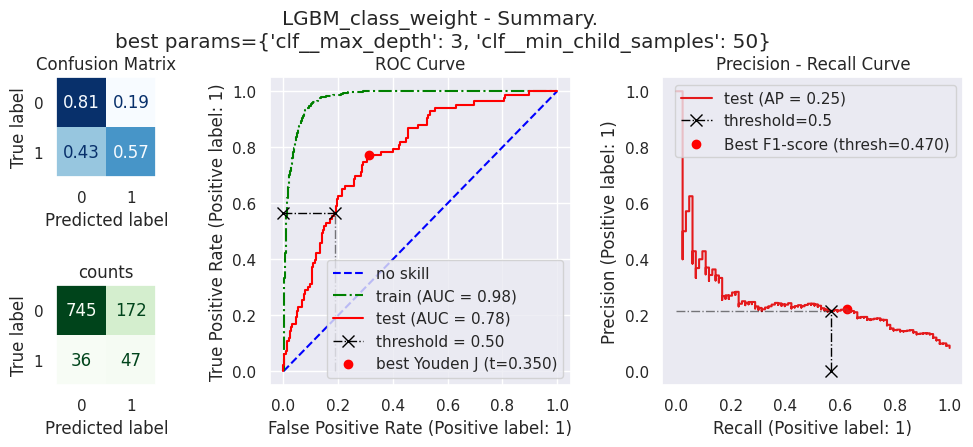

In [109]:
evaluate_model(Experience, LGBM_CW_pipeline, X_o_train, y_o_train,
            X_o_val, y_o_val, param_grid)

In [110]:
LGBM_cw_opt = df_scores_models.loc[df_scores_models["Experience"] == "LGBM_class_weight"]
LGBM_cw_opt

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,...,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
6,LGBM_class_weight,"{'clf__max_depth': 3, 'clf__min_child_samples'...",0.246,16.678,0.566,0.215,0.792,0.311,0.426,0.533,...,0.00228,0.712546,0.024158,0.922692,0.003294,0.354277,0.059775,0.796383,0.007061,0.5


In [111]:
log_mlflow(LGBM_CW_pipeline, "LGBM_opt_classWeight",
           Bussines_Metric=LGBM_cw_opt.bussines_metric,
           Recall=LGBM_cw_opt.recall,
           Precision=LGBM_cw_opt.precision,
           Accuracy=LGBM_cw_opt.accuracy,
           F1_score=LGBM_cw_opt.f1_score, F2_score=LGBM_cw_opt.f2_score,
           F5_score=LGBM_cw_opt.f5_score, F10_score=LGBM_cw_opt.f10_score,
           Roc_auc=LGBM_cw_opt.roc_auc,
           AP_score=LGBM_cw_opt.ap_score,
           TN=LGBM_cw_opt.tn, FP=LGBM_cw_opt.fp,
           FN=LGBM_cw_opt.fn, TP=LGBM_cw_opt.tp,
           train_class_0=Counter(y_o_train)[0],
           train_class_1=Counter(y_o_train)[1])

<a id='model_comparison'></a>


## <span style='background:#0085dd'><span style='color:white'>Model comparison</span></span>


In [112]:
# Open the table recording scores associated to best parameters for each model
path_score_models = 'model_tests/df_scores_models.pkl'

with open(path_score_models, 'rb') as f:
    df_scores_models = pickle.load(f)

In [113]:
pd.set_option('display.max_columns', 200)

In [114]:
def plot_cv_scores(scores_models: pd.DataFrame, score='roc_auc', cible=None, figname=''):

    """Compare the cross-validation scores of each model on the train dataset"""

    scores_models = scores_models.copy()
    if not cible is None:
        scores_models = scores_models[scores_models['Experience'].str.contains(
            cible, case=False, regex=True)]
        if not '|' in cible:
            # if cible is not a regular expression
            scores_models['Experience'] = scores_models['Experience'].str.replace(cible, '')

    if f'mean_train_{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[f'mean_train_{score}'],
                     yerr=scores_models[f'std_train_{score}'],
                     fmt="+",
                     color="royalblue",
                     label="Training score")
    if f'mean_test_{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[f'mean_test_{score}'],
                     yerr=scores_models[f'std_test_{score}'],
                     fmt="d",
                     color="lightsteelblue",
                     label="Cross-validation score")
    if f'{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[score],
                     yerr=0,
                     fmt="o",
                     color="red",
                     label="Test score")
    ax = plt.gca()
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.xlabel(f'Experience')
    plt.ylabel(f'score ({score})')
    sns.despine()
    suptitre = f'Cross-validation score ({score})'
    if not cible is None:
        suptitre += f' - {cible}'
    plt.suptitle(suptitre)
    plt.title(f"Score on training and test data sets")




In [115]:
df_scores_models

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,f10_score,bussines_metric,tn,fp,fn,tp,roc_auc,ap_score,model,best_cv_score,refit_time,mean_test_roc_auc,std_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
0,Baseline (Dummy),{},0.000,0.051,0.000,0.000,0.917,0.000,0.000,0.000,0.000,0.668,917,0,83,0,0.500,0.083,"(DummyClassifier(random_state=84, strategy='mo...",0.500000,0.000292,0.500000,0.000000,0.500000,0.000000,0.668369,0.001457,0.668367,0.000365,0.000000,0.000000,0.000000,0.000000,0.5
1,LogisticRegression_smote,"{'clf__penalty': 'l1', 'clf__solver': 'libline...",512.340,1774.758,0.672,0.827,0.766,0.741,0.698,0.677,0.673,0.701,788,129,301,616,0.766,0.720,"(LogisticRegression(penalty='l1', random_state...",0.938494,511.334144,0.938494,0.031703,0.966625,0.006009,0.887678,0.081095,0.909712,0.010504,0.885305,0.080721,0.909423,0.010451,0.5
2,RandomForest_smote,"{'clf__criterion': 'gini', 'clf__max_depth': 9}",3.689,167.211,0.827,0.967,0.899,0.891,0.851,0.831,0.828,0.849,891,26,159,758,0.899,0.886,"((DecisionTreeClassifier(max_depth=9, max_feat...",0.988618,3.693465,0.988618,0.020250,0.999250,0.000369,0.937703,0.100137,0.985738,0.006400,0.936475,0.100486,0.986109,0.006134,0.5
3,XGBoost_smote,"{'clf__gamma': 0.5, 'clf__learning_rate': 0.05...",4.730,695.338,0.881,0.991,0.937,0.933,0.901,0.885,0.882,0.898,910,7,109,808,0.937,0.933,"(XGBClassifier(base_score=None, booster=None, ...",0.988853,6.579671,0.988853,0.022146,0.999690,0.000157,0.921651,0.150200,0.981126,0.009450,0.918330,0.155728,0.982012,0.009009,0.5
4,LGBM_smote,"{'clf__max_depth': 9, 'clf__min_child_samples'...",1.168,37.139,0.889,0.993,0.941,0.938,0.908,0.892,0.890,0.905,911,6,102,815,0.941,0.938,"(LGBMClassifier(max_depth=9, min_child_samples...",0.990276,2.333642,0.990276,0.019447,1.000000,0.000000,0.922175,0.151876,1.000000,0.000000,0.918737,0.157633,1.000000,0.000000,0.5
5,LGBM_smote_under,"{'clf__max_depth': 7, 'clf__min_child_samples'...",0.645,20.233,0.812,0.951,0.885,0.876,0.837,0.817,0.813,0.835,439,19,86,372,0.885,0.867,"(LGBMClassifier(max_depth=7, min_child_samples...",0.974241,0.631357,0.974241,0.051324,1.000000,0.000000,0.841748,0.300145,0.999885,0.000231,0.816816,0.345328,0.999891,0.000218,0.5
6,LGBM_class_weight,"{'clf__max_depth': 3, 'clf__min_child_samples'...",0.246,16.678,0.566,0.215,0.792,0.311,0.426,0.533,0.557,0.731,745,172,36,47,0.689,0.158,"(LGBMClassifier(class_weight='balanced', max_d...",0.736839,0.206616,0.736839,0.028818,0.984770,0.002280,0.712546,0.024158,0.922692,0.003294,0.354277,0.059775,0.796383,0.007061,0.5


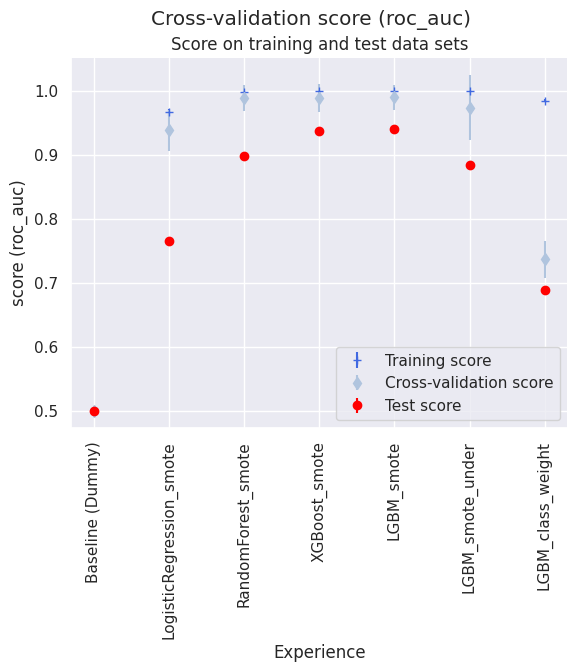

In [116]:
plot_cv_scores(df_scores_models)

In [117]:
df_scores_models.sort_values(by='roc_auc', ascending=False)

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,f10_score,bussines_metric,tn,fp,fn,tp,roc_auc,ap_score,model,best_cv_score,refit_time,mean_test_roc_auc,std_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
4,LGBM_smote,"{'clf__max_depth': 9, 'clf__min_child_samples'...",1.168,37.139,0.889,0.993,0.941,0.938,0.908,0.892,0.890,0.905,911,6,102,815,0.941,0.938,"(LGBMClassifier(max_depth=9, min_child_samples...",0.990276,2.333642,0.990276,0.019447,1.000000,0.000000,0.922175,0.151876,1.000000,0.000000,0.918737,0.157633,1.000000,0.000000,0.5
3,XGBoost_smote,"{'clf__gamma': 0.5, 'clf__learning_rate': 0.05...",4.730,695.338,0.881,0.991,0.937,0.933,0.901,0.885,0.882,0.898,910,7,109,808,0.937,0.933,"(XGBClassifier(base_score=None, booster=None, ...",0.988853,6.579671,0.988853,0.022146,0.999690,0.000157,0.921651,0.150200,0.981126,0.009450,0.918330,0.155728,0.982012,0.009009,0.5
2,RandomForest_smote,"{'clf__criterion': 'gini', 'clf__max_depth': 9}",3.689,167.211,0.827,0.967,0.899,0.891,0.851,0.831,0.828,0.849,891,26,159,758,0.899,0.886,"((DecisionTreeClassifier(max_depth=9, max_feat...",0.988618,3.693465,0.988618,0.020250,0.999250,0.000369,0.937703,0.100137,0.985738,0.006400,0.936475,0.100486,0.986109,0.006134,0.5
5,LGBM_smote_under,"{'clf__max_depth': 7, 'clf__min_child_samples'...",0.645,20.233,0.812,0.951,0.885,0.876,0.837,0.817,0.813,0.835,439,19,86,372,0.885,0.867,"(LGBMClassifier(max_depth=7, min_child_samples...",0.974241,0.631357,0.974241,0.051324,1.000000,0.000000,0.841748,0.300145,0.999885,0.000231,0.816816,0.345328,0.999891,0.000218,0.5
1,LogisticRegression_smote,"{'clf__penalty': 'l1', 'clf__solver': 'libline...",512.340,1774.758,0.672,0.827,0.766,0.741,0.698,0.677,0.673,0.701,788,129,301,616,0.766,0.720,"(LogisticRegression(penalty='l1', random_state...",0.938494,511.334144,0.938494,0.031703,0.966625,0.006009,0.887678,0.081095,0.909712,0.010504,0.885305,0.080721,0.909423,0.010451,0.5
6,LGBM_class_weight,"{'clf__max_depth': 3, 'clf__min_child_samples'...",0.246,16.678,0.566,0.215,0.792,0.311,0.426,0.533,0.557,0.731,745,172,36,47,0.689,0.158,"(LGBMClassifier(class_weight='balanced', max_d...",0.736839,0.206616,0.736839,0.028818,0.984770,0.002280,0.712546,0.024158,0.922692,0.003294,0.354277,0.059775,0.796383,0.007061,0.5
0,Baseline (Dummy),{},0.000,0.051,0.000,0.000,0.917,0.000,0.000,0.000,0.000,0.668,917,0,83,0,0.500,0.083,"(DummyClassifier(random_state=84, strategy='mo...",0.500000,0.000292,0.500000,0.000000,0.500000,0.000000,0.668369,0.001457,0.668367,0.000365,0.000000,0.000000,0.000000,0.000000,0.5


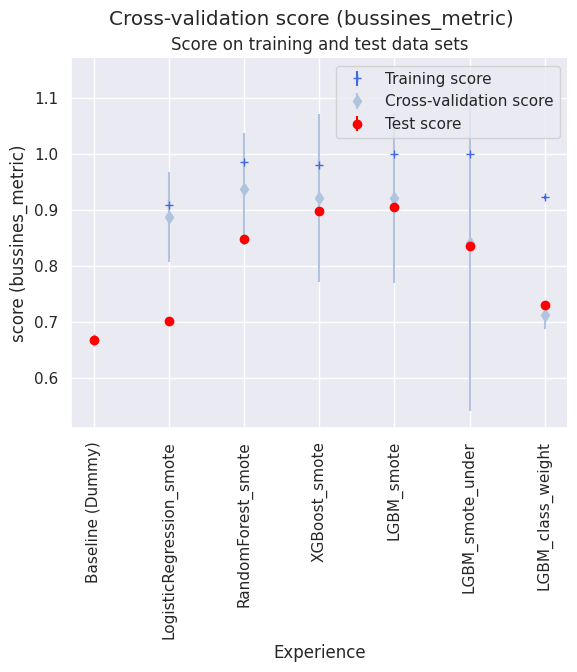

In [118]:
plot_cv_scores(df_scores_models, score='bussines_metric')

In [237]:
df_scores_models.sort_values(by='bussines_metric', ascending=False)

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,f10_score,bussines_metric,roc_auc,ap_score,model,best_cv_score,refit_time,mean_test_roc_auc,std_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
2,XGBoost_smote,"{'clf__gamma': 0.5, 'clf__learning_rate': 0.05...",6.194,2929.095,0.869,0.990,0.930,0.926,0.891,0.873,0.870,0.888,0.930,0.926,"(XGBClassifier(base_score=None, booster=None, ...",0.988214,6.431477,0.988214,0.023393,0.999865,0.000077,0.923642,0.144857,0.988663,0.005818,0.920666,0.149699,0.989213,0.005535,0.5
3,LGBM_smote,"{'clf__max_depth': 9, 'clf__min_child_samples'...",1.029,90.549,0.867,0.993,0.930,0.925,0.889,0.871,0.868,0.886,0.930,0.927,"(LGBMClassifier(max_depth=9, min_child_samples...",0.989057,1.283775,0.989057,0.021879,1.000000,0.000000,0.922678,0.150975,1.000000,0.000000,0.919318,0.156607,1.000000,0.000000,0.5
4,LGBM_smote_under,"{'clf__max_depth': 8, 'clf__min_child_samples'...",0.775,61.473,0.828,0.936,0.885,0.878,0.847,0.831,0.828,0.845,0.885,0.861,"(LGBMClassifier(max_depth=8, min_child_samples...",0.978858,0.779927,0.978858,0.042117,1.000000,0.000000,0.840867,0.300857,1.000000,0.000000,0.815634,0.346356,1.000000,0.000000,0.5
1,RandomForest_smote,"{'clf__criterion': 'gini', 'clf__max_depth': 9}",3.259,151.300,0.818,0.959,0.891,0.883,0.843,0.823,0.819,0.841,0.891,0.875,"((DecisionTreeClassifier(max_depth=9, max_feat...",0.988985,3.199080,0.988985,0.019568,0.999348,0.000334,0.942860,0.093926,0.987363,0.006212,0.941552,0.093672,0.987618,0.005958,0.5
5,LGBM_class_weight,"{'clf__max_depth': 3, 'clf__min_child_samples'...",0.224,42.536,0.566,0.215,0.792,0.311,0.426,0.533,0.557,0.731,0.689,0.158,"(LGBMClassifier(class_weight='balanced', max_d...",0.736839,0.268767,0.736839,0.028818,0.984770,0.002280,0.712546,0.024158,0.922692,0.003294,0.354277,0.059775,0.796383,0.007061,0.5
0,Baseline (Dummy),{},0.000,0.068,0.000,0.000,0.917,0.000,0.000,0.000,0.000,0.668,0.500,0.083,"(DummyClassifier(random_state=84, strategy='mo...",0.500000,0.002388,0.500000,0.000000,0.500000,0.000000,0.668369,0.001457,0.668367,0.000365,0.000000,0.000000,0.000000,0.000000,0.5


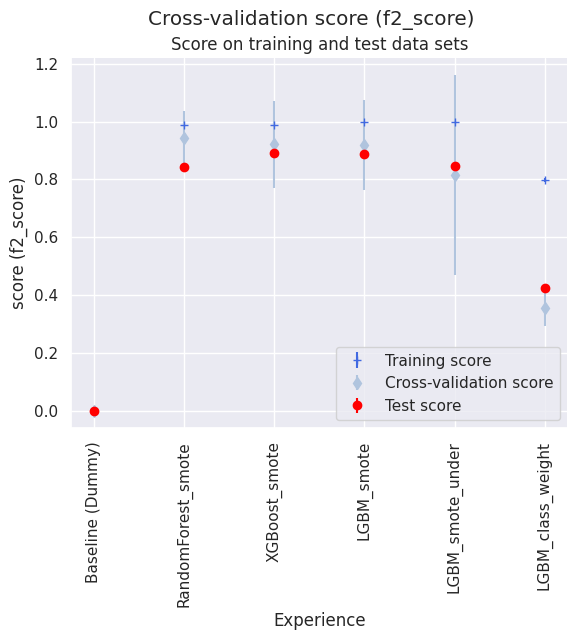

In [238]:
plot_cv_scores(df_scores_models, score='f2_score')

In [239]:
df_scores_models.sort_values(by='f2_score', ascending=False)

,Experience,params,train_time,gridsearch_time,recall,precision,accuracy,f1_score,f2_score,f5_score,f10_score,bussines_metric,roc_auc,ap_score,model,best_cv_score,refit_time,mean_test_roc_auc,std_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_bussines_metric,std_test_bussines_metric,mean_train_bussines_metric,std_train_bussines_metric,mean_test_f2_score,std_test_f2_score,mean_train_f2_score,std_train_f2_score,discrimination_threshold
2,XGBoost_smote,"{'clf__gamma': 0.5, 'clf__learning_rate': 0.05...",6.194,2929.095,0.869,0.990,0.930,0.926,0.891,0.873,0.870,0.888,0.930,0.926,"(XGBClassifier(base_score=None, booster=None, ...",0.988214,6.431477,0.988214,0.023393,0.999865,0.000077,0.923642,0.144857,0.988663,0.005818,0.920666,0.149699,0.989213,0.005535,0.5
3,LGBM_smote,"{'clf__max_depth': 9, 'clf__min_child_samples'...",1.029,90.549,0.867,0.993,0.930,0.925,0.889,0.871,0.868,0.886,0.930,0.927,"(LGBMClassifier(max_depth=9, min_child_samples...",0.989057,1.283775,0.989057,0.021879,1.000000,0.000000,0.922678,0.150975,1.000000,0.000000,0.919318,0.156607,1.000000,0.000000,0.5
4,LGBM_smote_under,"{'clf__max_depth': 8, 'clf__min_child_samples'...",0.775,61.473,0.828,0.936,0.885,0.878,0.847,0.831,0.828,0.845,0.885,0.861,"(LGBMClassifier(max_depth=8, min_child_samples...",0.978858,0.779927,0.978858,0.042117,1.000000,0.000000,0.840867,0.300857,1.000000,0.000000,0.815634,0.346356,1.000000,0.000000,0.5
1,RandomForest_smote,"{'clf__criterion': 'gini', 'clf__max_depth': 9}",3.259,151.300,0.818,0.959,0.891,0.883,0.843,0.823,0.819,0.841,0.891,0.875,"((DecisionTreeClassifier(max_depth=9, max_feat...",0.988985,3.199080,0.988985,0.019568,0.999348,0.000334,0.942860,0.093926,0.987363,0.006212,0.941552,0.093672,0.987618,0.005958,0.5
5,LGBM_class_weight,"{'clf__max_depth': 3, 'clf__min_child_samples'...",0.224,42.536,0.566,0.215,0.792,0.311,0.426,0.533,0.557,0.731,0.689,0.158,"(LGBMClassifier(class_weight='balanced', max_d...",0.736839,0.268767,0.736839,0.028818,0.984770,0.002280,0.712546,0.024158,0.922692,0.003294,0.354277,0.059775,0.796383,0.007061,0.5
0,Baseline (Dummy),{},0.000,0.068,0.000,0.000,0.917,0.000,0.000,0.000,0.000,0.668,0.500,0.083,"(DummyClassifier(random_state=84, strategy='mo...",0.500000,0.002388,0.500000,0.000000,0.500000,0.000000,0.668369,0.001457,0.668367,0.000365,0.000000,0.000000,0.000000,0.000000,0.5


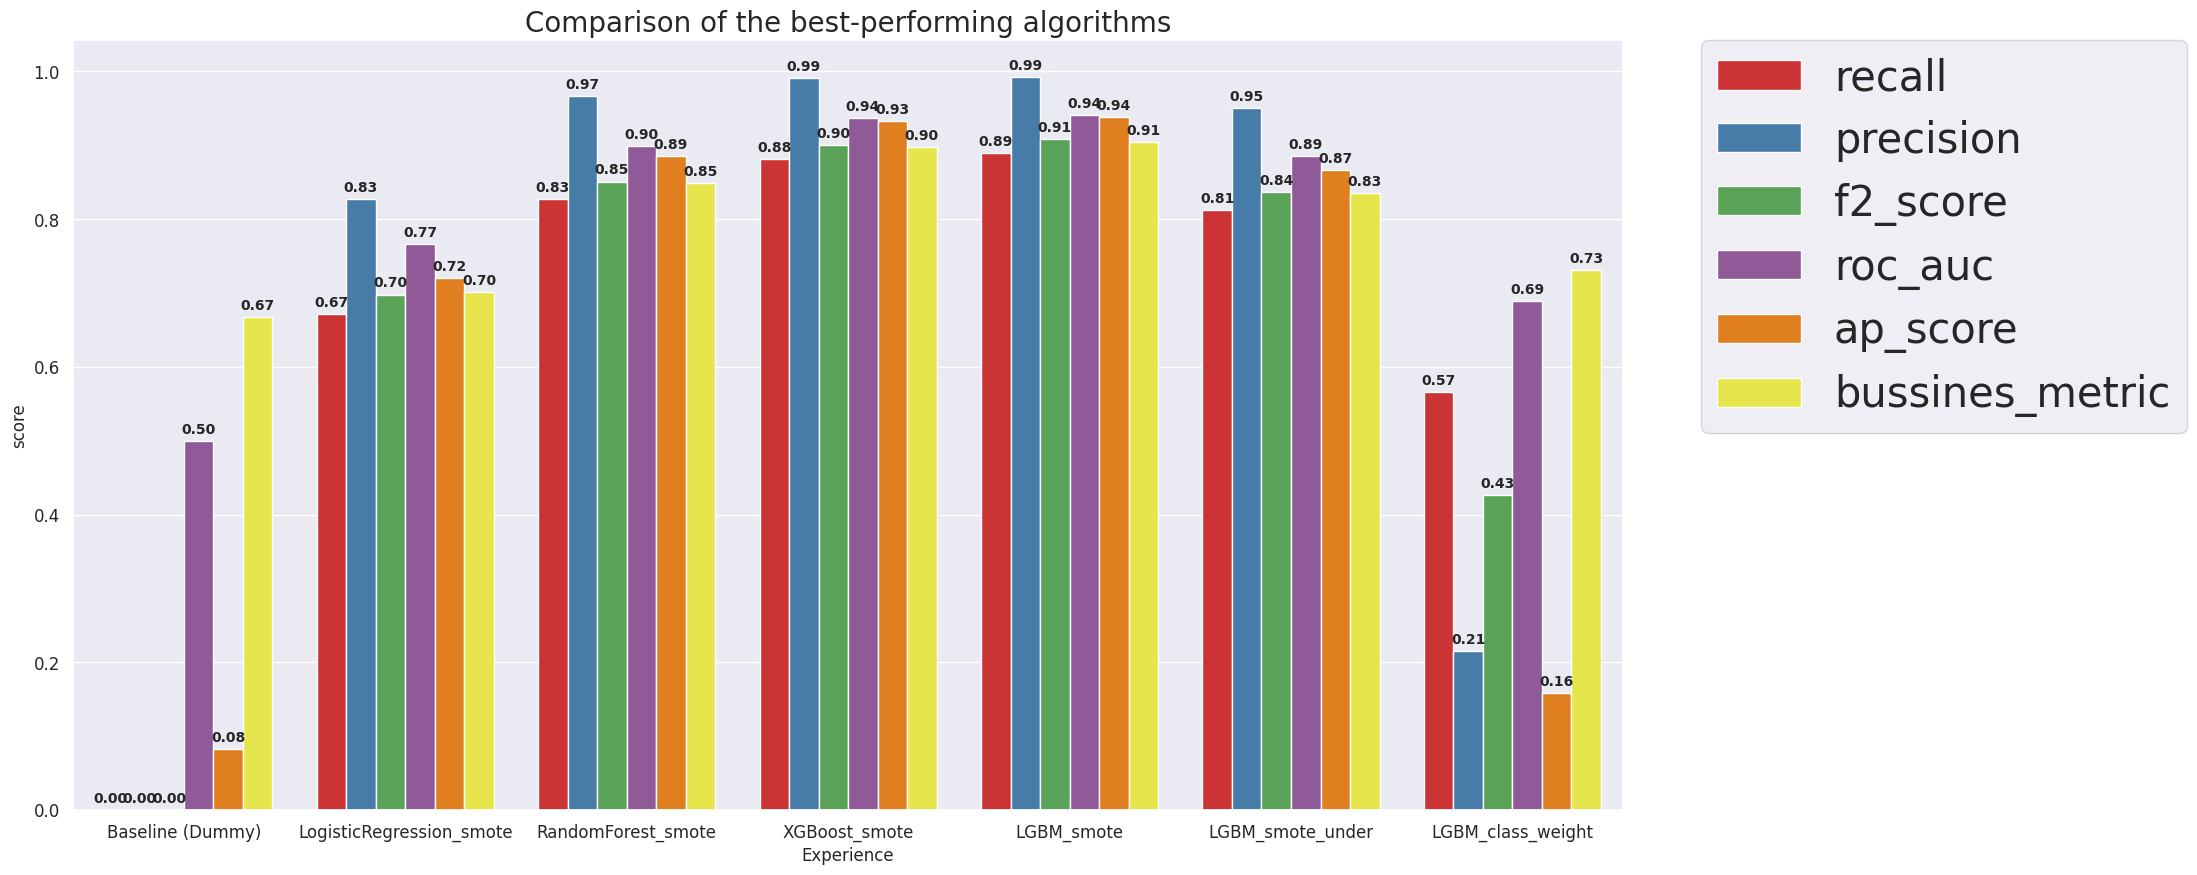

Experience,recall,precision,f2_score,roc_auc,ap_score,bussines_metric
Baseline (Dummy),0.000000,0.000000,0.000000,0.500000,0.083000,0.668000
LogisticRegression_smote,0.672000,0.827000,0.698000,0.766000,0.720000,0.701000
RandomForest_smote,0.827000,0.967000,0.851000,0.899000,0.886000,0.849000
XGBoost_smote,0.881000,0.991000,0.901000,0.937000,0.933000,0.898000
LGBM_smote,0.889000,0.993000,0.908000,0.941000,0.938000,0.905000
LGBM_smote_under,0.812000,0.951000,0.837000,0.885000,0.867000,0.835000
LGBM_class_weight,0.566000,0.215000,0.426000,0.689000,0.158000,0.731000


In [119]:
# Visual comparison of algorithms


# Scores
comparaison_models_melt = \
    pd.melt(df_scores_models, id_vars=['Experience'], value_name='score',
            value_vars=['recall', 'precision', 'f2_score',
                        'roc_auc', 'ap_score', 'bussines_metric'])
# Visualization
plt.figure(figsize=(20, 10))
ax= sns.barplot(x=comparaison_models_melt['Experience'],
                y=comparaison_models_melt['score'],
            hue=comparaison_models_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold') 
plt.show()

df_scores_models[['Experience', 'recall', 'precision', 'f2_score',
                        'roc_auc', 'ap_score', 'bussines_metric']].style.hide(axis="index")

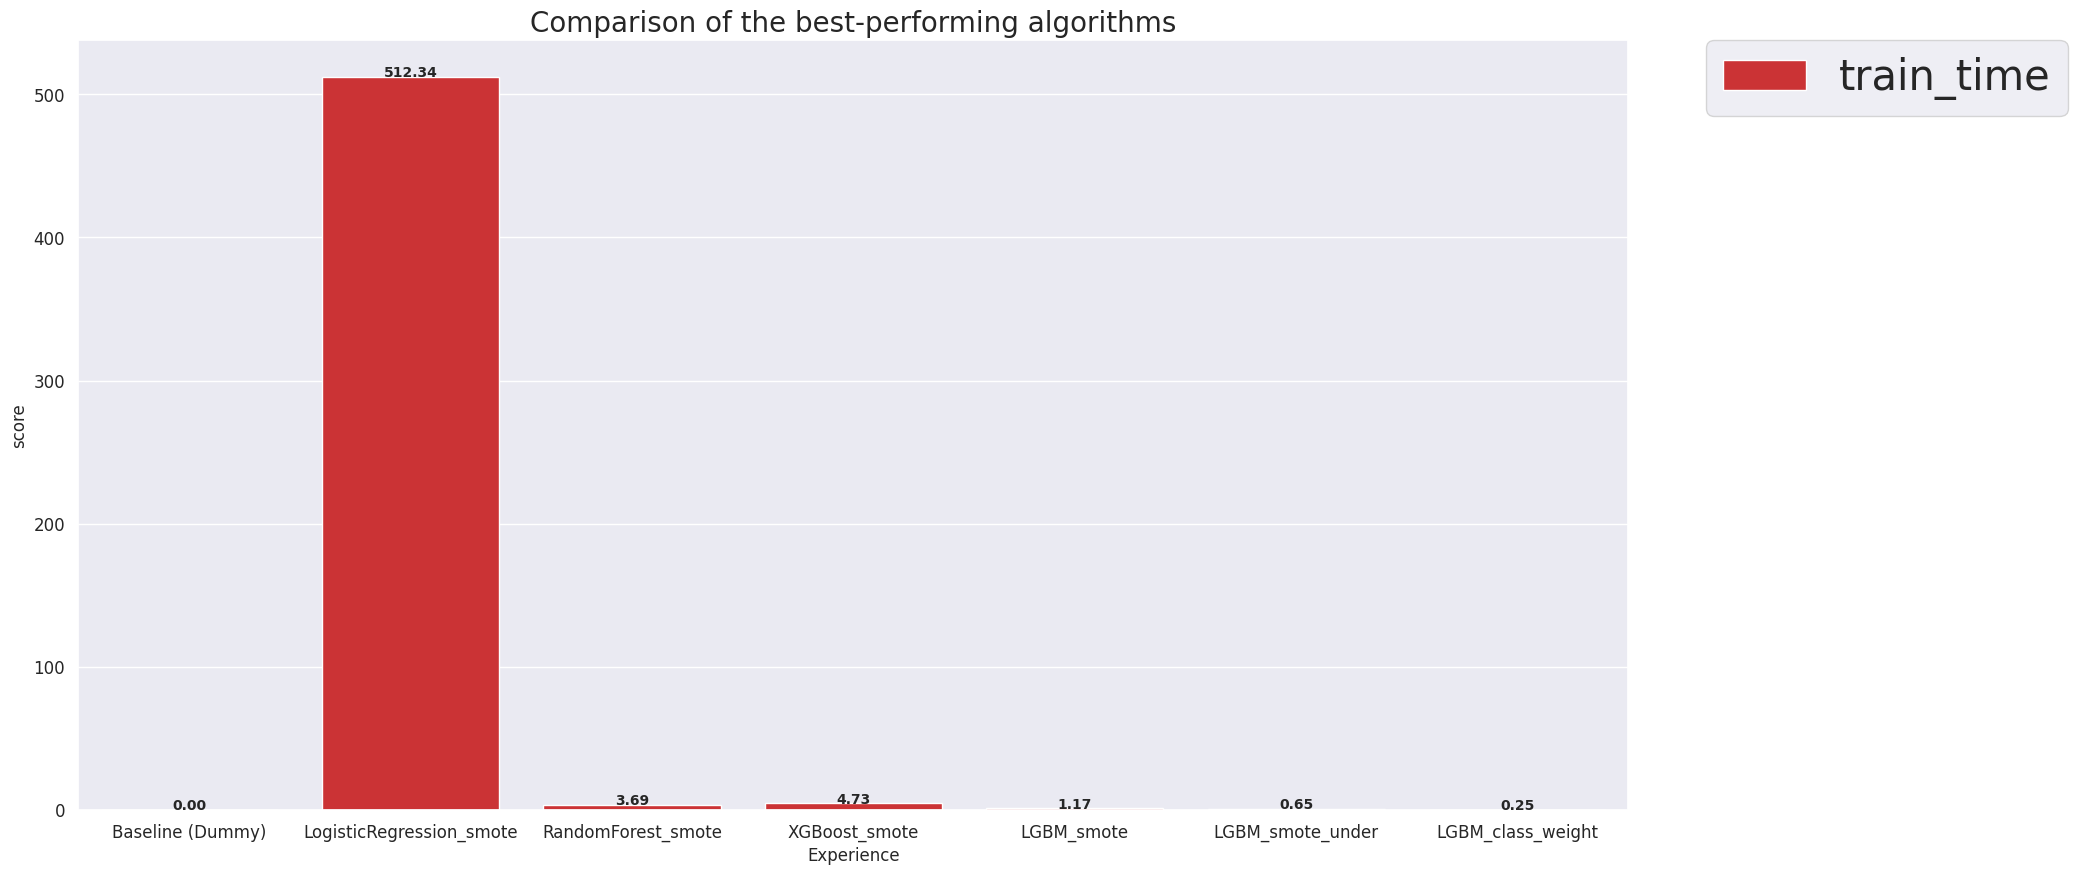

Experience,train_time
Baseline (Dummy),0.000000
LogisticRegression_smote,512.340000
RandomForest_smote,3.689000
XGBoost_smote,4.730000
LGBM_smote,1.168000
LGBM_smote_under,0.645000
LGBM_class_weight,0.246000


In [120]:
# Visual comparison of algorithms


# Scores
comparaison_models_melt = \
    pd.melt(df_scores_models, id_vars=['Experience'], value_name='score',
            value_vars=['train_time'])
# Visualization
plt.figure(figsize=(20, 10))
ax= sns.barplot(x=comparaison_models_melt['Experience'],
                y=comparaison_models_melt['score'],
            hue=comparaison_models_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold') 
plt.show()

df_scores_models[['Experience', 'train_time']].style.hide(axis="index")

<a id='best_model_selection'></a>


## <span style='background:#0085dd'><span style='color:white'>Best model selection</span></span>


The best results for scores are obtained using XG Boost and Light GBM.
Since the time needed for training is much shorter, **Light GBM will be implemented for the rest of the project**.

<a id='best_model'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Best model** </span></span>


<a id='load_full_data_train'></a>

## <span style='background:#0085dd'><span style='color:white'>Model training on the whole dataset</span></span>

In [22]:
# -----------------------------
# Files loading:
# -----------------------------

# Open final train_dataset
path_train_data = \
    'preprocessing/train_data_feat_select_ML.pkl'

with open(path_train_data, 'rb') as f:
    train_data = pickle.load(f)


# Open final test_dataset
path_test_data = \
    'preprocessing/test_data_feat_select_ML.pkl'
os.makedirs(os.path.dirname(path_test_data), exist_ok=True)

In [23]:
# Define target
y = train_data.pop('TARGET')
print(f'y : {y.shape}')

# Transfer of the customer identifier to the index for modelling purposes
train_data.set_index('SK_ID_CURR', inplace=True)
X = train_data
print(f'X : {X.shape}')

y : (307511,)
X : (307511, 488)


In [24]:
# Split dataset (filled)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=seed)

In [25]:
#-------------------------------
# Data rebalancing using SMOTE

# transform the dataset
oversample = SMOTE()

# transform the dataset
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)
X_val_SMOTE, y_val_SMOTE = oversample.fit_resample(X_val, y_val)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fbc97496670>
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<loc

In [26]:
# ----------------------------------------------
# Hyperparameter optimization with the whole dataset

Experience = 'LGBM_smote'

LGBM_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(random_state = seed))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__min_child_samples': [50]}

LGBM_pipeline

Pipeline(steps=[('clf', LGBMClassifier(random_state=84))])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV took 840.222 s
Best Parameters: {'clf__max_depth': 4, 'clf__min_child_samples': 50}
Best Train Score (roc_auc) : 0.980
Best Test Score (roc_auc): 0.973
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_smote; training time = 20.70675321306501 s; estimated gridsearch time (35 splits) = 742.972 s
add_model_score, model = LGBM_smote


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.912, 'precision': 0.997, 'accuracy': 0.955, 'f1_score': 0.953, 'f2_score': 0.928, 'f5_score': 0.915, 'f10_score': 0.913, 'bussines_metric': 0.925, 'tn': 56369, 'fp': 169, 'fn': 4958, 'tp': 51580, 'roc_auc': 0.978, 'ap_score': 0.984}
Plotting results for LGBM_smote with best_params : {'clf__max_depth': 4, 'clf__min_child_samples': 50}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       1.00      0.91      0.95     56538

    accuracy                           0.95    113076
   macro avg       0.96      0.95      0.95    113076
weighted avg       0.96      0.95      0.95    113076

1-specificity(FPR) = 0.00, sensitivity(TPR) 0.91


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.500 (score = 0.955)
best threshold for f2_score : 0.250 (score = 0.935)
best threshold for bussines_metric : 0.200 (score = 0.937)
Best Threshold=0.518, Youden J =0.909
Best Threshold=0.508, F-Score=0.953


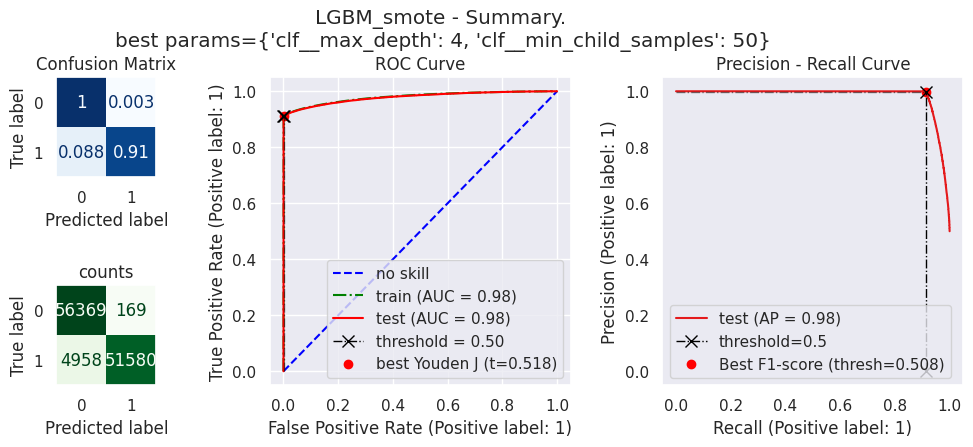

In [27]:
evaluate_model(Experience, LGBM_pipeline, X_train_SMOTE, y_train_SMOTE,
            X_val_SMOTE, y_val_SMOTE, param_grid)

In [28]:
# ---------------------------------------------
# Training the model with the best parameters

Experience = 'LGBM_smote_bestparams'
LGBM_best_params = dict(max_depth = 3, min_child_samples = 50)

LGBM_best_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(random_state = seed, **LGBM_best_params))])

LGBM_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 LGBMClassifier(max_depth=3, min_child_samples=50,
                                random_state=84))])

<a id='prob_threshold_finetuning'></a>

## <span style='background:#0085dd'><span style='color:white'>Bank benefit (score) optimising by pobability threshold fine-tuning</span></span>

The optimisation was done on the "roc_auc" metric (balance between false negatives and false positives):

We can then optimise the probability discrimination threshold (<span style='background:LightBlue'>**tools_modeling.prob_threshold**</span>.) for the bank to accept or reject a loan, based on: 
(a) the bussines metric created above; or 
(b) another profit and loss metric which can vary based on the amount of credit, repayment duration, ...

This section optimises the discrimination threshold for the <span style='background:LightBlue'>**tools_modeling.custom_score**</span> metric.

In [29]:
df_thresholds = pd.DataFrame()

In [30]:
# Discrimination threshold optimisation

def plot_vline(df, x_col, y_col, ax, color='k', line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    row_idx=0
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at {x_col}={line_x:.3f}'
    ax.axvline(line_x, c=color, linestyle="--", label=line_label)
    ax.legend(frameon=True)


def discrimination_threshold(clf: BaseEstimator, X_test, y_test,
                             score_func=custom_score,
                             label=None, color='b', ax=None):
    """
    Calculate scores as function of threshold for discriminating class 0 and class 1
    """

    scores = []
    thresholds = np.linspace(0, 1., 50, endpoint=False)

    # Probability of being in class TARGET==1
    y_proba = clf.predict_proba(X_test)[:, 1]
    for threshold in thresholds:
        # convert probability into class label, based on threshold
        y_pred = (y_proba > threshold)*1
        scores.append(score_func(y_test, y_pred, zero_division=0))
    if ax is None:
        _, ax = plt.subplots()
    if label is None:
        label = f'{score_func.__name__}'
    sns.lineplot(x=thresholds, y=scores, label=label, color=color, ax=ax)
    plot_vline(pd.DataFrame({'threshold': thresholds, 'score': scores}),
               'threshold', 'score', color=color, ax=ax)
    ax.set_xlabel("Discrimination threshold")
    ax.set_ylabel("Score")


Text(0.5, 0.98, 'LGBM best params - Calcul de seuil de probabilité optimal')

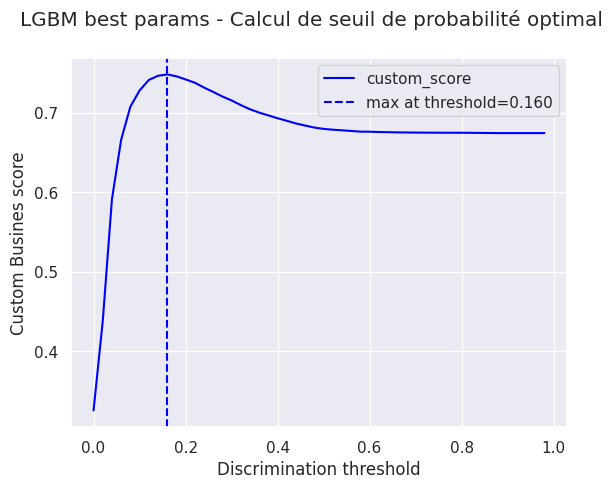

In [31]:
_, ax = plt.subplots()


discrimination_threshold(LGBM_best_pipeline, X_val, y_val, ax=ax)
ax.set_ylabel("Custom Busines score")

plt.suptitle('LGBM best params - Calcul de seuil de probabilité optimal')

Maximum business metric score : 0.7480425306068901
Optimal threshold : 0.16


,Thresholds,Gains
0,0.00,0.325688
1,0.01,0.351265
2,0.02,0.437996
3,0.03,0.528585
4,0.04,0.591230
...,...,...
95,0.95,0.674312
96,0.96,0.674312
97,0.97,0.674312
98,0.98,0.674312


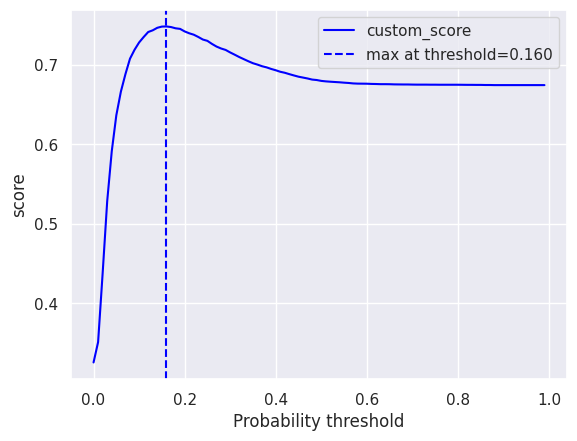

In [32]:
tools_modeling.prob_threshold(LGBM_best_pipeline, X_val, y_val, "LGBM best params", df_thresholds, n=1)

In [33]:
# ------------------------------------------------------------
# Effect of changing the weights of the 'custom_score' metric

def plot_probability_thresholds(model, X_val, y_val):
    _, ax = plt.subplots()
    colors = sns.color_palette('tab10').as_hex()

    # plot default threshold
    discrimination_threshold(model, X_val, y_val, color=colors[0], ax=ax)

    def score_fp_1(y_train, y_pred, **kwargs):
        return custom_score(y_train, y_pred, fp_loss=-0.5)


    # Reduce losses due to misclassification of a good customer
    discrimination_threshold(model, X_val, y_val, score_func=score_fp_1,
                            label='fp_loss = -0.2', color=colors[1], ax=ax)


    ax.grid(False)
    ax.set_ylabel("Business score")
    sns.despine()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 0.98, 'LGBM best params : Effet des couts des faux negatifs et faux positifs sur le seuil de probabilité optimal')

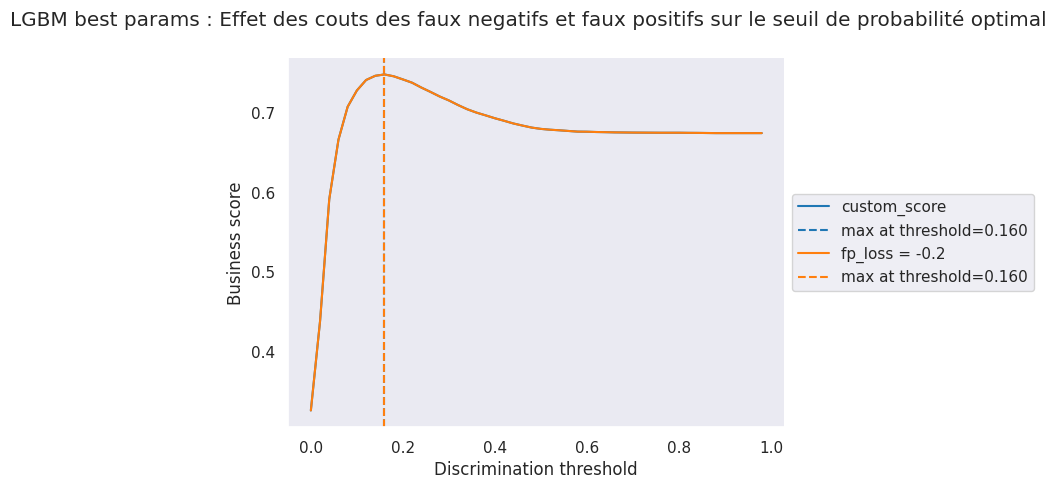

In [34]:

plot_probability_thresholds(LGBM_best_pipeline, X_val, y_val)

titre= 'LGBM best params'
titre+=' : Effet des couts des faux negatifs et faux positifs sur le seuil de probabilité optimal'
plt.suptitle(titre)

<a id='data_rebalancing'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**END** </span></span>
